# **Predicting Bleeding Risk in ICU Patients Receiving IV Heparin: A Machine Learning Approach for Early Intervention

# **Project Goal:
The goal of this project is to develop a predictive model that assesses the bleeding risk 
in ICU patients receiving IV heparin. The model will utilize a combination of heparin 
exposure data, demographics, lab values, comorbidities, and vital signs to predict whether 
a patient will experience a bleeding event within 48 hours of receiving heparin. 
The outcome of this model will be used to inform early intervention strategies in critical 
care to mitigate bleeding risks, enhance patient safety, and improve outcomes.

In [2]:
## **Step1-Data Collection:
## **Step2-Data Preprocessing:
## **Step3- Handling Missing Data:
# **Step4-Feature Engineering:

In [4]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Display utilities
from IPython.display import display

# SHAP for model interpretation
import shap

# Stats and math
from scipy.special import expit

# Machine Learning Preprocessing & Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, recall_score,
    confusion_matrix, roc_curve
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# PostgreSQL DB connection (if used)
import psycopg2

# Visualization settings
sns.set_style("whitegrid")
warnings.filterwarnings("ignore", message=".*shap values output has changed to a list.*")


In [5]:
conn = psycopg2.connect(host='localhost', port='5432', database='mimiciv')

In [6]:
query_heparin_itemids = """
SELECT itemid, label, category, linksto
FROM mimiciv_icu.d_items
WHERE LOWER(label) LIKE '%heparin%';
"""
df_heparin_items = pd.read_sql_query(query_heparin_itemids, conn)

# Get list of itemids as a tuple for SQL IN clause
heparin_itemids = tuple(df_heparin_items["itemid"].tolist())

# Show unique Heparin-related item IDs
unique_itemids = df_heparin_items["itemid"].unique()

/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/189595736.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_heparin_items = pd.read_sql_query(query_heparin_itemids, conn)


In [7]:
df_heparin_items

,itemid,label,category,linksto
0,224145,Heparin Dose (per hour),Dialysis,chartevents
1,225152,Heparin Sodium,Medications,inputevents
2,225958,Heparin Concentration (units/mL),Dialysis,chartevents
3,225975,Heparin Sodium (Prophylaxis),Medications,inputevents
4,229373,UF Heparin (Anti-Xa)_U_1,Labs,chartevents
5,229375,UF Heparin (Anti-Xa),Labs,chartevents
6,229538,PICC - Heparin Dependent,Access Lines - Invasive,chartevents
7,229597,Heparin Sodium (Impella),Medications,inputevents
8,230044,Heparin Sodium (CRRT-Prefilter),Medications,inputevents
9,224145,Heparin Dose (per hour),Dialysis,chartevents


In [12]:
##primary cohort for systemic Heparin exposure
heparin_itemids = (225152, 225975)

In [14]:
query_heparin = f"""
SELECT
  subject_id,
  hadm_id,
  stay_id,
  starttime AS heparin_start,
  endtime AS heparin_end,
  storetime AS order_recorded,
  itemid,
  amount,
  amountuom,
  rate,
  rateuom,
  orderid,
  ordercategoryname,
  secondaryordercategoryname,
  ordercomponenttypedescription,
  ordercategorydescription,
  patientweight,
  statusdescription
FROM mimiciv_icu.inputevents
WHERE itemid IN {heparin_itemids}
  AND amount IS NOT NULL
  AND statusdescription = 'FinishedRunning';
"""
df_heparin = pd.read_sql_query(query_heparin, conn)


/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/3781677479.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_heparin = pd.read_sql_query(query_heparin, conn)


In [15]:
df_heparin

,subject_id,hadm_id,stay_id,heparin_start,heparin_end,order_recorded,itemid,amount,amountuom,rate,rateuom,orderid,ordercategoryname,secondaryordercategoryname,ordercomponenttypedescription,ordercategorydescription,patientweight,statusdescription
0,10000690,25860671,37081114,2150-11-06 08:00:00,2150-11-06 08:01:00,2150-11-06 09:39:00,225975,1.0,dose,NaN,None,2837137,11-Prophylaxis (Non IV),None,Main order parameter,Drug Push,55.3,FinishedRunning
1,10000690,25860671,37081114,2150-11-04 08:43:00,2150-11-04 08:44:00,2150-11-04 08:43:00,225975,1.0,dose,NaN,None,3285592,11-Prophylaxis (Non IV),None,Main order parameter,Drug Push,55.3,FinishedRunning
2,10000690,25860671,37081114,2150-11-04 13:35:00,2150-11-04 13:36:00,2150-11-04 13:35:00,225975,1.0,dose,NaN,None,1272118,11-Prophylaxis (Non IV),None,Main order parameter,Drug Push,55.3,FinishedRunning
3,10000690,25860671,37081114,2150-11-03 22:18:00,2150-11-03 22:19:00,2150-11-03 22:18:00,225975,1.0,dose,NaN,None,8262720,11-Prophylaxis (Non IV),None,Main order parameter,Drug Push,55.3,FinishedRunning
4,10000980,26913865,39765666,2189-06-27 12:54:00,2189-06-27 12:55:00,2189-06-27 12:54:00,225152,4000.0,units,NaN,None,1704375,05-Med Bolus,None,Main order parameter,Drug Push,76.2,FinishedRunning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399939,19999840,21033226,38978960,2164-09-13 07:59:00,2164-09-13 08:00:00,2164-09-13 07:59:00,225975,1.0,dose,NaN,None,2458727,11-Prophylaxis (Non IV),None,Main order parameter,Drug Push,77.5,FinishedRunning
399940,19999840,21033226,38978960,2164-09-15 20:00:00,2164-09-15 20:01:00,2164-09-15 20:27:00,225975,1.0,dose,NaN,None,1129511,11-Prophylaxis (Non IV),None,Main order parameter,Drug Push,77.5,FinishedRunning
399941,19999840,21033226,38978960,2164-09-12 22:06:00,2164-09-12 22:07:00,2164-09-12 22:06:00,225975,1.0,dose,NaN,None,1243926,11-Prophylaxis (Non IV),None,Main order parameter,Drug Push,77.5,FinishedRunning
399942,19999840,21033226,38978960,2164-09-15 14:02:00,2164-09-15 14:03:00,2164-09-15 14:02:00,225975,1.0,dose,NaN,None,3863188,11-Prophylaxis (Non IV),None,Main order parameter,Drug Push,77.5,FinishedRunning


In [16]:
#-----399944 rows × 18 columns

In [17]:
#Join ICU Stay Data (intime, outtime)

In [18]:
query_icu = """
SELECT subject_id, hadm_id, stay_id, intime, outtime
FROM mimiciv_icu.icustays;
"""
df_icu = pd.read_sql_query(query_icu, conn)

# Merge and keep only records where Heparin was given during ICU stay
df_heparin = df_heparin.merge(df_icu, on=['subject_id', 'hadm_id', 'stay_id'])
df_heparin = df_heparin[
    (df_heparin['heparin_start'] >= df_heparin['intime']) &
    (df_heparin['heparin_start'] <= df_heparin['outtime'])
]

/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/2105535430.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_icu = pd.read_sql_query(query_icu, conn)


In [19]:
#Create Time Windows
df_heparin["window_start"] = df_heparin["heparin_start"]
df_heparin["window_end"] = df_heparin["heparin_start"] + pd.Timedelta(hours=48)

In [20]:
#Add Demographics
query_demo = """
SELECT p.subject_id, p.gender, p.anchor_year, p.anchor_age,
       a.hadm_id, a.race, a.admission_type
FROM mimiciv_hosp.patients p
JOIN mimiciv_hosp.admissions a ON p.subject_id = a.subject_id;
"""
df_demo = pd.read_sql_query(query_demo, conn)

df_heparin = df_heparin.merge(df_demo, on=['subject_id', 'hadm_id'])

# Calculate age at ICU admission
df_heparin["age"] = pd.to_datetime(df_heparin["heparin_start"]).dt.year - df_heparin["anchor_year"] + df_heparin["anchor_age"]


/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/190684332.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_demo = pd.read_sql_query(query_demo, conn)


In [21]:
#OUTCOME VARIBLES 
# Define item IDs
lab_item_map = {
    "hgb": 50811,
    "hct": 51221,
    "inr": 51237,
    "aptt": 50862
}
antixa_itemids = (229373, 229375)

# Function to get labs from labevents
def get_lab_df(itemid, label):
    query = f"""
    SELECT subject_id, hadm_id, charttime, valuenum
    FROM mimiciv_hosp.labevents
    WHERE itemid = {itemid} AND valuenum IS NOT NULL;
    """
    df = pd.read_sql_query(query, conn)
    df["lab_type"] = label
    return df

# Download labs
df_labs = pd.concat([
    get_lab_df(lab_item_map["hgb"], "hgb"),
    get_lab_df(lab_item_map["hct"], "hct"),
    get_lab_df(lab_item_map["inr"], "inr"),
    get_lab_df(lab_item_map["aptt"], "aptt")
])

# Download Anti-Xa from chartevents
query_antixa = f"""
SELECT subject_id, hadm_id, charttime, valuenum
FROM mimiciv_icu.chartevents
WHERE itemid IN {antixa_itemids}
  AND valuenum IS NOT NULL;
"""
df_antixa = pd.read_sql_query(query_antixa, conn)
df_antixa["lab_type"] = "antixa"

# Combine all labs
df_all_labs = pd.concat([df_labs, df_antixa])

# Merge labs with Heparin cohort window
df_lab_window = df_all_labs.merge(
    df_heparin[["subject_id", "hadm_id", "window_start", "window_end"]],
    on=["subject_id", "hadm_id"],
    how="inner"
)

# Filter to labs within the window
df_lab_window = df_lab_window[
    (df_lab_window["charttime"] >= df_lab_window["window_start"]) &
    (df_lab_window["charttime"] <= df_lab_window["window_end"])
]

# Initialize outcomes table
outcomes = df_heparin[["subject_id", "hadm_id"]].drop_duplicates().copy()

# HGB drop ≥ 2 g/dL
hgb = df_lab_window[df_lab_window["lab_type"] == "hgb"]
hgb_summary = hgb.groupby(["subject_id", "hadm_id"])["valuenum"].agg(["min", "max"]).reset_index()
hgb_summary["bleed_hgb"] = (hgb_summary["max"] - hgb_summary["min"] >= 2).astype(int)

# HCT drop ≥ 6%
hct = df_lab_window[df_lab_window["lab_type"] == "hct"]
hct_summary = hct.groupby(["subject_id", "hadm_id"])["valuenum"].agg(["min", "max"]).reset_index()
hct_summary["bleed_hct"] = (hct_summary["max"] - hct_summary["min"] >= 6).astype(int)

# INR ≥ 3.0
inr = df_lab_window[df_lab_window["lab_type"] == "inr"]
inr_summary = inr.groupby(["subject_id", "hadm_id"])["valuenum"].max().reset_index()
inr_summary["bleed_inr"] = (inr_summary["valuenum"] >= 3.0).astype(int)

# aPTT ≥ 80
aptt = df_lab_window[df_lab_window["lab_type"] == "aptt"]
aptt_summary = aptt.groupby(["subject_id", "hadm_id"])["valuenum"].max().reset_index()
aptt_summary["bleed_aptt"] = (aptt_summary["valuenum"] >= 80).astype(int)

# Anti-Xa ≥ 1.0
antixa = df_lab_window[df_lab_window["lab_type"] == "antixa"]
antixa_summary = antixa.groupby(["subject_id", "hadm_id"])["valuenum"].max().reset_index()
antixa_summary["bleed_antixa"] = (antixa_summary["valuenum"] >= 1.0).astype(int)

# Merge all indicators into the outcome table
outcomes = outcomes.merge(hgb_summary[["subject_id", "hadm_id", "bleed_hgb"]], on=["subject_id", "hadm_id"], how="left")
outcomes = outcomes.merge(hct_summary[["subject_id", "hadm_id", "bleed_hct"]], on=["subject_id", "hadm_id"], how="left")
outcomes = outcomes.merge(inr_summary[["subject_id", "hadm_id", "bleed_inr"]], on=["subject_id", "hadm_id"], how="left")
outcomes = outcomes.merge(aptt_summary[["subject_id", "hadm_id", "bleed_aptt"]], on=["subject_id", "hadm_id"], how="left")
outcomes = outcomes.merge(antixa_summary[["subject_id", "hadm_id", "bleed_antixa"]], on=["subject_id", "hadm_id"], how="left")

# Fill missing with 0s
outcomes.fillna(0, inplace=True)

# Create composite bleeding outcome
outcomes["bleeding_event"] = (
    outcomes["bleed_hgb"].astype(bool) |
    outcomes["bleed_hct"].astype(bool) |
    outcomes["bleed_inr"].astype(bool) |
    outcomes["bleed_aptt"].astype(bool) |
    outcomes["bleed_antixa"].astype(bool)
).astype(int)

# Merge into df_heparin
df_heparin = df_heparin.merge(outcomes, on=["subject_id", "hadm_id"], how="left")

# Final safety step: ensure bleeding_event is 0 where missing
df_heparin["bleeding_event"] = df_heparin["bleeding_event"].fillna(0).astype(int)


/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/1979141040.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/1979141040.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/1979141040.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/var/folders/3_/0cs1sd196_scl_z87dl52

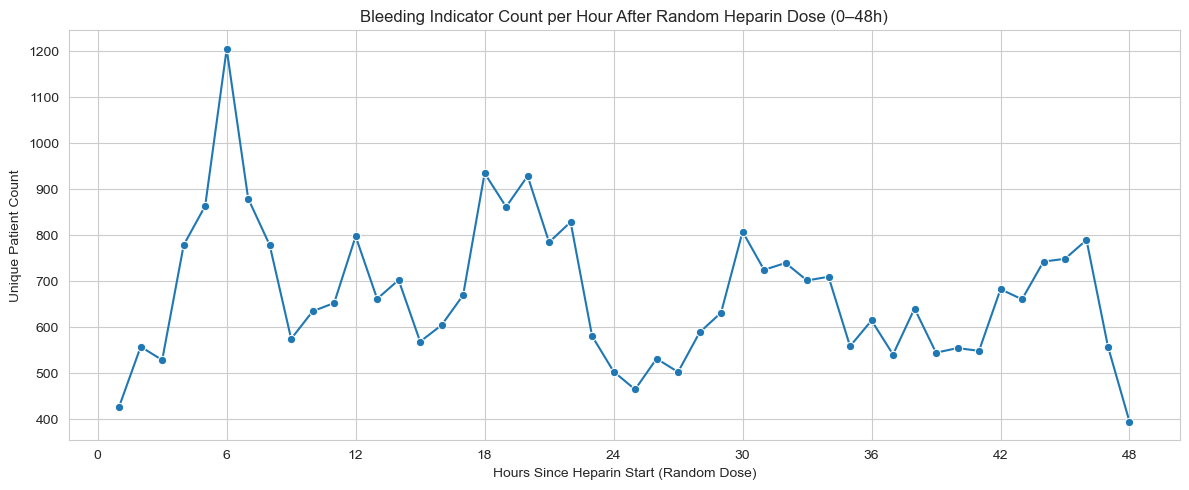

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define bleeding thresholds
bleed_thresholds = {
    "hgb": lambda x: x <= 10,
    "hct": lambda x: x <= 30,
    "inr": lambda x: x >= 3.0,
    "aptt": lambda x: x >= 80,
    "antixa": lambda x: x >= 1.0
}

# 2. Randomly select one heparin dose per patient
# Assume df_heparin has columns: subject_id, hadm_id, heparin_start, heparin_end, route, amount
df_heparin_unique = (
    df_heparin
    .sort_values("heparin_start")
    .groupby("subject_id", group_keys=False)
    .sample(1, random_state=42)
)

# 3. Merge lab data with selected dose
df_merged = pd.merge(df_lab_window, df_heparin_unique, on=["subject_id", "hadm_id"])

# Calculate time from selected heparin start
df_merged["hours_since_start"] = (
    (df_merged["charttime"] - df_merged["heparin_start"]).dt.total_seconds() / 3600
).round().astype(int)

# Limit to 0–48 hour window
df_merged = df_merged[(df_merged["hours_since_start"] > 0) & (df_merged["hours_since_start"] <= 48)]

# 4. Apply thresholds to find bleeding events
df_bleeds = pd.DataFrame()
for lab_type, condition in bleed_thresholds.items():
    subset = df_merged[df_merged["lab_type"] == lab_type].copy()
    subset = subset[condition(subset["valuenum"])]
    df_bleeds = pd.concat([df_bleeds, subset])

# 5. Count unique patients with bleeding per hour
bleed_count_by_hour = (
    df_bleeds.groupby("hours_since_start")[["subject_id", "hadm_id"]]
    .apply(lambda x: x.drop_duplicates().shape[0])
    .reset_index(name="patient_count")
)

# 6. Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=bleed_count_by_hour, x="hours_since_start", y="patient_count", marker='o')
plt.title("Bleeding Indicator Count per Hour After Random Heparin Dose (0–48h)")
plt.xlabel("Hours Since Heparin Start (Random Dose)")
plt.ylabel("Unique Patient Count")
plt.grid(True)
plt.xticks(np.arange(0, 49, 6))
plt.tight_layout()
plt.show()


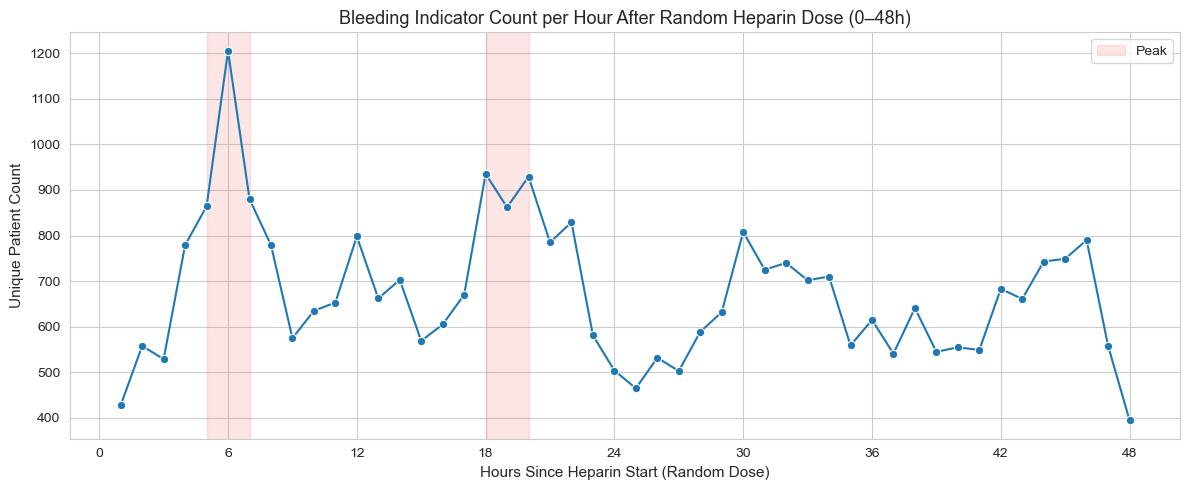

In [30]:
##highlight
plt.figure(figsize=(12, 5))

# Main plot
sns.lineplot(data=bleed_count_by_hour, x="hours_since_start", y="patient_count", marker='o')

# Title and labels
plt.title("Bleeding Indicator Count per Hour After Random Heparin Dose (0–48h)", fontsize=13)
plt.xlabel("Hours Since Heparin Start (Random Dose)", fontsize=11)
plt.ylabel("Unique Patient Count", fontsize=11)

# Highlight the first peak region (~5–7h)
plt.axvspan(5, 7, color='lightcoral', alpha=0.2, label='Peak')

# Highlight the second peak region (~17–19h)
plt.axvspan(18, 20, color='lightcoral', alpha=0.2)

# Grid and axis formatting
plt.grid(True)
plt.xticks(np.arange(0, 49, 6))
plt.tight_layout()
plt.legend()
plt.show()


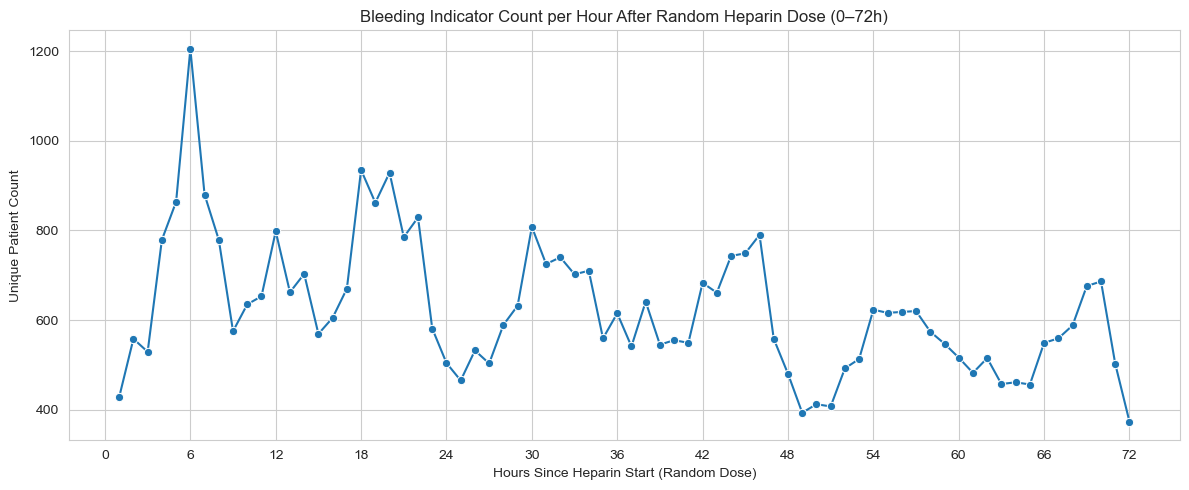

In [29]:
"""
###plot the 72 to see the diffrance only ///change the window in cell ~11##

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define bleeding thresholds
bleed_thresholds = {
    "hgb": lambda x: x <= 10,
    "hct": lambda x: x <= 30,
    "inr": lambda x: x >= 3.0,
    "aptt": lambda x: x >= 80,
    "antixa": lambda x: x >= 1.0
}

# 2. Randomly select one heparin dose per patient
# Assume df_heparin has columns: subject_id, hadm_id, heparin_start, heparin_end, route, amount
df_heparin_unique = (
    df_heparin
    .sort_values("heparin_start")
    .groupby("subject_id", group_keys=False)
    .sample(1, random_state=42)  # ensure reproducibility
)

# 3. Merge labs with selected dose based on subject_id and stay within 72h window
df_merged = pd.merge(df_lab_window, df_heparin_unique, on=["subject_id", "hadm_id"])

# Calculate time from selected dose
df_merged["hours_since_start"] = (
    (df_merged["charttime"] - df_merged["heparin_start"]).dt.total_seconds() / 3600
).round().astype(int)

# Keep only labs within 0–72 hours after selected heparin dose
df_merged = df_merged[(df_merged["hours_since_start"] > 0) & (df_merged["hours_since_start"] <= 72)]

# 4. Apply bleeding thresholds to identify events
df_bleeds = pd.DataFrame()
for lab_type, condition in bleed_thresholds.items():
    subset = df_merged[df_merged["lab_type"] == lab_type].copy()
    subset = subset[condition(subset["valuenum"])]
    df_bleeds = pd.concat([df_bleeds, subset])

# 5. Count unique patients with bleeding per hour
bleed_count_by_hour = (
    df_bleeds.groupby("hours_since_start")[["subject_id", "hadm_id"]]
    .apply(lambda x: x.drop_duplicates().shape[0])
    .reset_index(name="patient_count")
)

# 6. Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=bleed_count_by_hour, x="hours_since_start", y="patient_count", marker='o')
plt.title("Bleeding Indicator Count per Hour After Random Heparin Dose (0–72h)")
plt.xlabel("Hours Since Heparin Start (Random Dose)")
plt.ylabel("Unique Patient Count")
plt.grid(True)
plt.xticks(np.arange(0, 73, 6))
plt.tight_layout()
plt.show()
"""

In [61]:
df_heparin

,subject_id,hadm_id,stay_id,heparin_start,heparin_end,order_recorded,itemid,amount,amountuom,rate,...,anchor_age,race,admission_type,age,bleed_hgb,bleed_hct,bleed_inr,bleed_aptt,bleed_antixa,bleeding_event
0,10000690,25860671,37081114,2150-11-06 08:00:00,2150-11-06 08:01:00,2150-11-06 09:39:00,225975,1.0,dose,NaN,...,86,WHITE,EW EMER.,86,0.0,0.0,0.0,0.0,0.0,0
1,10000690,25860671,37081114,2150-11-06 08:00:00,2150-11-06 08:01:00,2150-11-06 09:39:00,225975,1.0,dose,NaN,...,86,WHITE,EW EMER.,86,0.0,0.0,0.0,0.0,0.0,0
2,10000690,25860671,37081114,2150-11-06 08:00:00,2150-11-06 08:01:00,2150-11-06 09:39:00,225975,1.0,dose,NaN,...,86,WHITE,EW EMER.,86,0.0,0.0,0.0,0.0,0.0,0
3,10000690,25860671,37081114,2150-11-04 08:43:00,2150-11-04 08:44:00,2150-11-04 08:43:00,225975,1.0,dose,NaN,...,86,WHITE,EW EMER.,86,0.0,0.0,0.0,0.0,0.0,0
4,10000690,25860671,37081114,2150-11-04 08:43:00,2150-11-04 08:44:00,2150-11-04 08:43:00,225975,1.0,dose,NaN,...,86,WHITE,EW EMER.,86,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197961,19999840,21033226,38978960,2164-09-15 20:00:00,2164-09-15 20:01:00,2164-09-15 20:27:00,225975,1.0,dose,NaN,...,58,WHITE,EW EMER.,58,0.0,0.0,0.0,0.0,0.0,0
1197962,19999840,21033226,38978960,2164-09-15 20:00:00,2164-09-15 20:01:00,2164-09-15 20:27:00,225975,1.0,dose,NaN,...,58,WHITE,EW EMER.,58,0.0,0.0,0.0,0.0,0.0,0
1197963,19999840,21033226,38978960,2164-09-12 22:06:00,2164-09-12 22:07:00,2164-09-12 22:06:00,225975,1.0,dose,NaN,...,58,WHITE,EW EMER.,58,0.0,0.0,0.0,0.0,0.0,0
1197964,19999840,21033226,38978960,2164-09-12 22:06:00,2164-09-12 22:07:00,2164-09-12 22:06:00,225975,1.0,dose,NaN,...,58,WHITE,EW EMER.,58,0.0,0.0,0.0,0.0,0.0,0


In [31]:
df_heparin["bleeding_event"].value_counts()

bleeding_event
1    686682
0    511284
Name: count, dtype: int64

In [32]:
df_heparin["bleeding_event"].value_counts(normalize=True) * 100

bleeding_event
1    57.320659
0    42.679341
Name: proportion, dtype: float64

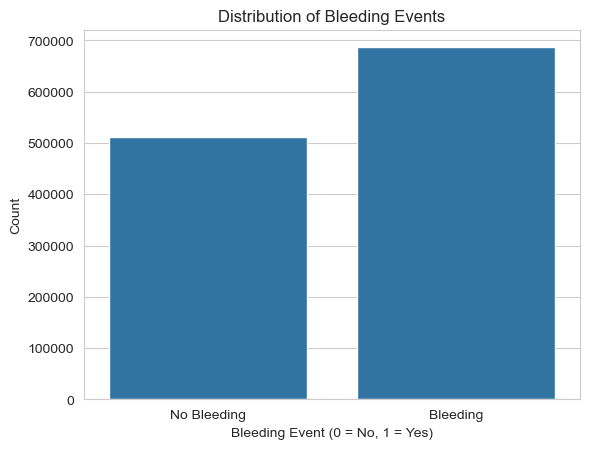

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="bleeding_event", data=df_heparin)
plt.title("Distribution of Bleeding Events")
plt.xlabel("Bleeding Event (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.xticks([0, 1], ['No Bleeding', 'Bleeding'])
plt.show()

In [34]:
df_heparin.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'heparin_start', 'heparin_end',
       'order_recorded', 'itemid', 'amount', 'amountuom', 'rate', 'rateuom',
       'orderid', 'ordercategoryname', 'secondaryordercategoryname',
       'ordercomponenttypedescription', 'ordercategorydescription',
       'patientweight', 'statusdescription', 'intime', 'outtime',
       'window_start', 'window_end', 'gender', 'anchor_year', 'anchor_age',
       'race', 'admission_type', 'age', 'bleed_hgb', 'bleed_hct', 'bleed_inr',
       'bleed_aptt', 'bleed_antixa', 'bleeding_event'],
      dtype='object')

# *Feature Extraction

## **Extract Vitals from chartevents Within Time Window

In [44]:
###Extract Labs in the Same Window

#Lab	itemid	Description
#Hemoglobin	50811	Oxygen-carrying capacity
#Hematocrit	51221	RBC % volume
#Platelet	51265	Bleeding/clotting risk
#INR	51237	Coagulation
#aPTT	50862	Coagulation
#Creatinine	50912	Renal function
#BUN	51006	Renal/metabolic status
#Sodium	50983	Electrolyte balance
#Potassium	50971	Electrolyte balance

# Cleaned and Corrected Script for Feature Construction

# Step 1: Define lab item IDs
lab_itemids = {
    "Platelets": 51265,
    "Creatinine": 50912,
    "BUN": 51006,
    "Sodium": 50983,
    "Potassium": 50971,
    "PT": 51274,
    "Fibrinogen": 50809,
    "Albumin": 50862,
    "Total_Bilirubin": 50885,
    "Calcium": 50893,
    "Magnesium": 50960,
    "Lactate": 50813,
    "AST": 50861,
    "ALT": 50878,
    "D_dimer": 51256
}

# Step 2: Pull labs
query_labs = f"""
SELECT subject_id, hadm_id, charttime, itemid, valuenum
FROM mimiciv_hosp.labevents
WHERE itemid IN {tuple(lab_itemids.values())}
  AND valuenum IS NOT NULL;
"""
df_labs = pd.read_sql_query(query_labs, conn)

# Step 3: Map itemid to lab name
df_labs["lab_type"] = df_labs["itemid"].map({v: k for k, v in lab_itemids.items()})

# Step 4: Merge with window start/end
df_labs = df_labs.merge(
    df_heparin[["subject_id", "hadm_id", "window_start", "window_end"]].drop_duplicates(),
    on=["subject_id", "hadm_id"],
    how="inner"
)

# Step 5: Filter to labs within window
df_labs = df_labs[(df_labs["charttime"] >= df_labs["window_start"]) &
                  (df_labs["charttime"] <= df_labs["window_end"])]

# Step 6: Aggregate lab values by mean, min, max, std
df_labs_agg = df_labs.groupby(["subject_id", "hadm_id", "lab_type"])["valuenum"].agg(["mean", "min", "max", "std"]).reset_index()

# Step 7: Pivot labs to wide format
df_labs_wide = df_labs_agg.pivot(index=["subject_id", "hadm_id"], columns="lab_type")
df_labs_wide.columns = [f"{stat}_{lab}" for lab, stat in df_labs_wide.columns]
df_labs_wide = df_labs_wide.reset_index()

# Step 8: Extract Heparin Exposure Features
df_heparin_features = df_heparin[[
    "subject_id", "hadm_id",
    "amount", "rate", "amountuom", "rateuom",
    "ordercategoryname", "ordercomponenttypedescription"
]].drop_duplicates()

# Step 9: Construct final df_features with bleeding_event, labs, and heparin features
df_features = df_heparin[["subject_id", "hadm_id", "bleeding_event"]].drop_duplicates()
df_features = df_features.merge(df_labs_wide, on=["subject_id", "hadm_id"], how="left")
df_features = df_features.merge(df_heparin_features, on=["subject_id", "hadm_id"], how="left")


/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/1480525615.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_labs = pd.read_sql_query(query_labs, conn)


In [45]:
df_features.columns

Index(['subject_id', 'hadm_id', 'bleeding_event', 'ALT_mean', 'AST_mean',
       'Albumin_mean', 'BUN_mean', 'Calcium_mean', 'Creatinine_mean',
       'D_dimer_mean', 'Fibrinogen_mean', 'Lactate_mean', 'Magnesium_mean',
       'PT_mean', 'Platelets_mean', 'Potassium_mean', 'Sodium_mean',
       'Total_Bilirubin_mean', 'ALT_min', 'AST_min', 'Albumin_min', 'BUN_min',
       'Calcium_min', 'Creatinine_min', 'D_dimer_min', 'Fibrinogen_min',
       'Lactate_min', 'Magnesium_min', 'PT_min', 'Platelets_min',
       'Potassium_min', 'Sodium_min', 'Total_Bilirubin_min', 'ALT_max',
       'AST_max', 'Albumin_max', 'BUN_max', 'Calcium_max', 'Creatinine_max',
       'D_dimer_max', 'Fibrinogen_max', 'Lactate_max', 'Magnesium_max',
       'PT_max', 'Platelets_max', 'Potassium_max', 'Sodium_max',
       'Total_Bilirubin_max', 'ALT_std', 'AST_std', 'Albumin_std', 'BUN_std',
       'Calcium_std', 'Creatinine_std', 'D_dimer_std', 'Fibrinogen_std',
       'Lactate_std', 'Magnesium_std', 'PT_std', 'Platel

## **Comorbidities

In [47]:
## Extract Comorbidities from diagnoses_icd
#Comorbidity Flags to Include:
#Comorbidity	ICD Code Starts With	Meaning
#Liver Disease	K70, K71, K72, K74	Risk of coagulopathy
#Renal Disease	N17, N18	Affects drug clearance
#Cancer (Solid)	C00–C80	Affects bleeding/clotting risk
#Coagulopathy / Bleeding disorders	D65–D69	Includes platelet/clotting issues
#Hypertension	I10–I15	Background CV risk

In [48]:
# Pull diagnosis codes
query_dx = """
SELECT subject_id, hadm_id, icd_code
FROM mimiciv_hosp.diagnoses_icd;
"""
df_dx = pd.read_sql_query(query_dx, conn)

# Use first 3 characters for grouping
df_dx["icd_prefix"] = df_dx["icd_code"].str[:3]

# Create comorbidity flags
comorbidity_flags = {
    "Comorbidities_liver_disease": ["K70", "K71", "K72", "K74"],
    "Comorbidities_renal_disease": ["N17", "N18"],
    "Comorbidities_cancer": [f"C{str(i).zfill(2)}" for i in range(0, 81)],
    "Comorbidities_coagulopathy": [f"D{str(i)}" for i in range(65, 70)],
    "Comorbidities_hypertension": [f"I{str(i)}" for i in range(10, 16)]
}

# Initialize comorbidity table
df_comorb = df_dx[["subject_id", "hadm_id"]].drop_duplicates().copy()

for name, codes in comorbidity_flags.items():
    df_flag = df_dx[df_dx["icd_prefix"].isin(codes)][["subject_id", "hadm_id"]].drop_duplicates()
    df_flag[name] = 1
    df_comorb = df_comorb.merge(df_flag, on=["subject_id", "hadm_id"], how="left")

# Fill NaNs with 0
df_comorb.fillna(0, inplace=True)

/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/3288975820.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_dx = pd.read_sql_query(query_dx, conn)


In [49]:
df_features = df_features.merge(df_comorb, on=["subject_id", "hadm_id"], how="left")

In [50]:
df_features

,subject_id,hadm_id,bleeding_event,ALT_mean,AST_mean,Albumin_mean,BUN_mean,Calcium_mean,Creatinine_mean,D_dimer_mean,...,rate,amountuom,rateuom,ordercategoryname,ordercomponenttypedescription,Comorbidities_liver_disease,Comorbidities_renal_disease,Comorbidities_cancer,Comorbidities_coagulopathy,Comorbidities_hypertension
0,10000690,25860671,0,14.000000,9.000000,3.0,19.909091,9.145455,0.800000,NaN,...,NaN,dose,None,11-Prophylaxis (Non IV),Main order parameter,0.0,0.0,0.0,0.0,0.0
1,10000980,26913865,1,21.000000,12.000000,4.1,40.000000,9.400000,2.233333,73.20,...,NaN,units,None,05-Med Bolus,Main order parameter,0.0,0.0,0.0,0.0,0.0
2,10001217,24597018,0,NaN,NaN,NaN,7.500000,8.750000,0.450000,NaN,...,NaN,dose,None,11-Prophylaxis (Non IV),Main order parameter,0.0,0.0,0.0,0.0,0.0
3,10001884,26184834,1,278.800000,455.400000,3.2,34.062500,8.893750,1.168750,NaN,...,1045.907349,units,units/hour,01-Drips,Main order parameter,1.0,0.0,0.0,1.0,1.0
4,10001884,26184834,1,278.800000,455.400000,3.2,34.062500,8.893750,1.168750,NaN,...,NaN,units,None,05-Med Bolus,Main order parameter,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60994,19999287,20175828,0,NaN,NaN,NaN,10.687500,9.468750,0.656250,NaN,...,NaN,dose,None,11-Prophylaxis (Non IV),Main order parameter,0.0,0.0,0.0,0.0,0.0
60995,19999287,22997012,0,NaN,NaN,NaN,11.000000,8.900000,0.800000,NaN,...,NaN,dose,None,11-Prophylaxis (Non IV),Main order parameter,0.0,0.0,0.0,0.0,0.0
60996,19999442,26785317,1,20.000000,63.000000,3.9,19.304348,8.752174,0.704348,NaN,...,NaN,dose,None,11-Prophylaxis (Non IV),Main order parameter,0.0,0.0,0.0,0.0,0.0
60997,19999625,25304202,0,NaN,NaN,3.3,45.200000,8.550000,2.180000,88.70,...,NaN,dose,None,11-Prophylaxis (Non IV),Main order parameter,0.0,0.0,0.0,0.0,0.0


## **Demographic

In [52]:
#  demographic data
# Pull demographic data
query_demo = """
SELECT
  p.subject_id,
  p.gender,
  p.anchor_year,
  p.anchor_age,
  a.hadm_id,
  a.race,
  a.admission_type,
  a.marital_status
FROM mimiciv_hosp.patients p
JOIN mimiciv_hosp.admissions a
  ON p.subject_id = a.subject_id;
"""
df_demo = pd.read_sql_query(query_demo, conn)

# Step 2: Merge with heparin_start for age calculation
df_demo = df_demo.merge(
    df_heparin[["subject_id", "hadm_id", "heparin_start"]].drop_duplicates(),
    on=["subject_id", "hadm_id"],
    how="inner"
)

# Step 3: Compute true age and group
df_demo["age"] = pd.to_datetime(df_demo["heparin_start"]).dt.year - df_demo["anchor_year"] + df_demo["anchor_age"]
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 150]
labels = ['10-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91+']
df_demo["age_group"] = pd.cut(df_demo["age"], bins=bins, labels=labels, right=False)

# Step 4: One-hot encode all categories with 0/1
df_demo_encoded = pd.get_dummies(
    df_demo,
    columns=["gender", "race", "admission_type", "marital_status", "age_group"],
    drop_first=False,
    dtype=int  # Ensures output is integers (0/1)
)

# Step 5: Drop raw age and merge
df_demo_encoded.drop(columns=["age"], inplace=True)

# Step 6: Merge with main feature matrix
df_features = df_features.merge(df_demo_encoded, on=["subject_id", "hadm_id"], how="left")

/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/1567162492.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_demo = pd.read_sql_query(query_demo, conn)


In [53]:
df_features.columns

Index(['subject_id', 'hadm_id', 'bleeding_event', 'ALT_mean', 'AST_mean',
       'Albumin_mean', 'BUN_mean', 'Calcium_mean', 'Creatinine_mean',
       'D_dimer_mean',
       ...
       'marital_status_WIDOWED', 'age_group_10-20', 'age_group_21-30',
       'age_group_31-40', 'age_group_41-50', 'age_group_51-60',
       'age_group_61-70', 'age_group_71-80', 'age_group_81-90',
       'age_group_91+'],
      dtype='object', length=134)

In [54]:
df_features.head(3)

,subject_id,hadm_id,bleeding_event,ALT_mean,AST_mean,Albumin_mean,BUN_mean,Calcium_mean,Creatinine_mean,D_dimer_mean,...,marital_status_WIDOWED,age_group_10-20,age_group_21-30,age_group_31-40,age_group_41-50,age_group_51-60,age_group_61-70,age_group_71-80,age_group_81-90,age_group_91+
0,10000690,25860671,0,14.0,9.0,3.0,19.909091,9.145455,0.8,NaN,...,1,0,0,0,0,0,0,0,1,0
1,10000690,25860671,0,14.0,9.0,3.0,19.909091,9.145455,0.8,NaN,...,1,0,0,0,0,0,0,0,1,0
2,10000690,25860671,0,14.0,9.0,3.0,19.909091,9.145455,0.8,NaN,...,1,0,0,0,0,0,0,0,1,0


## **Medications

In [56]:
# Extract medications that increase bleeding risk from mimiciv_hosp.prescriptions and pivot by patient
#if given with/before heaprin

In [57]:
bleeding_risk_meds = [
    'warfarin', 'aspirin', 'clopidogrel','enoxaparin', 'rivaroxaban',
    'apixaban', 'dabigatran', 'tinzaparin', 'fondaparinux', 'ticagrelor', 'abciximab',
    'eptifibatide', 'tirofiban', 'alteplase', 'streptokinase'
]


In [58]:
query_bleeding_meds = f"""
SELECT subject_id, hadm_id, LOWER(drug) AS drug
FROM mimiciv_hosp.prescriptions
WHERE LOWER(drug) IN ({','.join(["'" + med + "'" for med in bleeding_risk_meds])})
"""
df_meds = pd.read_sql_query(query_bleeding_meds, conn)

/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/3768079664.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_meds = pd.read_sql_query(query_bleeding_meds, conn)


In [59]:
df_meds['drug'] = df_meds['drug'].str.lower().str.strip()
df_meds['flag'] = 1
df_meds_pivot = df_meds.pivot_table(index=['subject_id', 'hadm_id'], 
                                     columns='drug', values='flag', fill_value=0).reset_index()
df_meds_pivot.columns.name = None  # Clean column name


In [60]:
df_features = df_features.merge(df_meds_pivot, on=['subject_id', 'hadm_id'], how='left')
df_features.fillna(0, inplace=True)  


In [61]:
df_features

,subject_id,hadm_id,bleeding_event,ALT_mean,AST_mean,Albumin_mean,BUN_mean,Calcium_mean,Creatinine_mean,D_dimer_mean,...,aspirin,clopidogrel,dabigatran,enoxaparin,eptifibatide,fondaparinux,rivaroxaban,ticagrelor,tirofiban,warfarin
0,10000690,25860671,0,14.000000,9.000000,3.0,19.909091,9.145455,0.800000,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10000690,25860671,0,14.000000,9.000000,3.0,19.909091,9.145455,0.800000,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10000690,25860671,0,14.000000,9.000000,3.0,19.909091,9.145455,0.800000,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10000690,25860671,0,14.000000,9.000000,3.0,19.909091,9.145455,0.800000,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10000980,26913865,1,21.000000,12.000000,4.1,40.000000,9.400000,2.233333,73.20,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842432,19999840,21033226,0,75.888889,73.111111,0.0,14.560000,8.004000,0.728000,79.45,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
842433,19999840,21033226,0,75.888889,73.111111,0.0,14.560000,8.004000,0.728000,79.45,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
842434,19999840,21033226,0,75.888889,73.111111,0.0,14.560000,8.004000,0.728000,79.45,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
842435,19999840,21033226,0,75.888889,73.111111,0.0,14.560000,8.004000,0.728000,79.45,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Vital

In [78]:
# Define vital item IDs with descriptions
# Step 1: Define vital item IDs
vital_itemids = {
    "HR": 211,              # Heart Rate
    "SBP": 51,              # Systolic Blood Pressure
    "DBP": 8368,            # Diastolic Blood Pressure
    "RR": 618,              # Respiratory Rate
    "O2Sat": 220277,        # O2 Saturation
    "Temp": 223761          # Temperature
}

# Step 2: Query vital signs from chartevents
query_vitals = f"""
SELECT subject_id, hadm_id, charttime, itemid, valuenum
FROM mimiciv_icu.chartevents
WHERE itemid IN {tuple(vital_itemids.values())}
  AND valuenum IS NOT NULL;
"""
df_vitals = pd.read_sql_query(query_vitals, conn)

# Step 3: Map itemid to label
df_vitals["vital_type"] = df_vitals["itemid"].map({v: k for k, v in vital_itemids.items()})

# Step 4: Merge with cohort window to filter values
df_vitals = df_vitals.merge(
    df_heparin[["subject_id", "hadm_id", "window_start", "window_end"]].drop_duplicates(),
    on=["subject_id", "hadm_id"],
    how="inner"
)

# Step 5: Filter within the time window
df_vitals = df_vitals[
    (df_vitals["charttime"] >= df_vitals["window_start"]) &
    (df_vitals["charttime"] <= df_vitals["window_end"])
]

# Step 6: Aggregate vitals
df_vitals_agg = df_vitals.groupby(["subject_id", "hadm_id", "vital_type"])["valuenum"].agg(
    ["mean", "min", "max", "std"]
).reset_index()

# Step 7: Pivot to wide format
df_vitals_wide = df_vitals_agg.pivot(index=["subject_id", "hadm_id"], columns="vital_type")
df_vitals_wide.columns = [f"{stat}_{vital}" for vital, stat in df_vitals_wide.columns]
df_vitals_wide = df_vitals_wide.reset_index()

# Step 8: Merge with your existing feature dataset
df_features = df_features.merge(df_vitals_wide, on=["subject_id", "hadm_id"], how="left")

/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/3153591379.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_vitals = pd.read_sql_query(query_vitals, conn)


## **procedures

In [80]:
# procedures with timestamps
query_proc = """
SELECT subject_id, hadm_id, starttime AS procedure_time, itemid
FROM mimiciv_ICU.procedureevents;
"""
df_proc = pd.read_sql_query(query_proc, conn)

# Merge with Heparin window
df_proc = df_proc.merge(
    df_heparin[["subject_id", "hadm_id", "window_start", "window_end"]].drop_duplicates(),
    on=["subject_id", "hadm_id"],
    how="inner"
)

# Filter procedures within window
df_proc_windowed = df_proc[
    (df_proc["procedure_time"] >= df_proc["window_start"]) &
    (df_proc["procedure_time"] <= df_proc["window_end"])
]

#  Create had_surgery flag
df_surgery_flag = df_proc_windowed[["subject_id", "hadm_id"]].drop_duplicates()
df_surgery_flag["had_surgery"] = 1

#  Merge into your main features
df_features = df_features.merge(df_surgery_flag, on=["subject_id", "hadm_id"], how="left")
df_features["had_surgery"] = df_features["had_surgery"].fillna(0).astype(int)

/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/4270032861.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_proc = pd.read_sql_query(query_proc, conn)


In [81]:
df_features

,subject_id,hadm_id,bleeding_event,ALT_mean,AST_mean,Albumin_mean,BUN_mean,Calcium_mean,Creatinine_mean,D_dimer_mean,...,warfarin,O2Sat_mean,Temp_mean,O2Sat_min,Temp_min,O2Sat_max,Temp_max,O2Sat_std,Temp_std,had_surgery
0,10000690,25860671,0,14.000000,9.000000,3.0,19.909091,9.145455,0.800000,0.00,...,0.0,95.903846,97.821875,86.0,96.8,100.0,101.1,3.517122,1.155452,1
1,10000690,25860671,0,14.000000,9.000000,3.0,19.909091,9.145455,0.800000,0.00,...,0.0,95.903846,97.821875,86.0,96.8,100.0,101.1,3.517122,1.155452,1
2,10000690,25860671,0,14.000000,9.000000,3.0,19.909091,9.145455,0.800000,0.00,...,0.0,95.903846,97.821875,86.0,96.8,100.0,101.1,3.517122,1.155452,1
3,10000690,25860671,0,14.000000,9.000000,3.0,19.909091,9.145455,0.800000,0.00,...,0.0,95.903846,97.821875,86.0,96.8,100.0,101.1,3.517122,1.155452,1
4,10000980,26913865,1,21.000000,12.000000,4.1,40.000000,9.400000,2.233333,73.20,...,0.0,98.166667,98.700000,96.0,98.7,100.0,98.7,1.749459,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842432,19999840,21033226,0,75.888889,73.111111,0.0,14.560000,8.004000,0.728000,79.45,...,0.0,96.066474,97.918571,91.0,95.8,100.0,99.2,2.359494,0.873147,1
842433,19999840,21033226,0,75.888889,73.111111,0.0,14.560000,8.004000,0.728000,79.45,...,0.0,96.066474,97.918571,91.0,95.8,100.0,99.2,2.359494,0.873147,1
842434,19999840,21033226,0,75.888889,73.111111,0.0,14.560000,8.004000,0.728000,79.45,...,0.0,96.066474,97.918571,91.0,95.8,100.0,99.2,2.359494,0.873147,1
842435,19999840,21033226,0,75.888889,73.111111,0.0,14.560000,8.004000,0.728000,79.45,...,0.0,96.066474,97.918571,91.0,95.8,100.0,99.2,2.359494,0.873147,1


## **Feature based on shap(frist try )

In [83]:
##based on shap
interaction_pairs = [
    ('BUN_mean', 'Creatinine_mean'),
    ('Platelets_mean', 'Potassium_mean'),
    ('Sodium_mean', 'Potassium_mean'),
    ('Comorbidities_renal_disease', 'Creatinine_mean'),
    ('amount', 'rate'),
    ('anchor_age', 'Platelets_mean')
]


In [84]:
for col1, col2 in interaction_pairs:
    new_col = f"{col1}_x_{col2}"
    df_features[new_col] = df_features[col1] * df_features[col2]

In [85]:
##Ratio derived from corresponding lab values related the the case 

In [86]:
df_features["BUN_to_Creatinine"] = df_features["BUN_mean"] / (df_features["Creatinine_mean"] + 1e-6)
df_features["Sodium_to_Potassium"] = df_features["Sodium_mean"] / (df_features["Potassium_mean"] + 1e-6)

In [87]:
df_features.head(3)

,subject_id,hadm_id,bleeding_event,ALT_mean,AST_mean,Albumin_mean,BUN_mean,Calcium_mean,Creatinine_mean,D_dimer_mean,...,Temp_std,had_surgery,BUN_mean_x_Creatinine_mean,Platelets_mean_x_Potassium_mean,Sodium_mean_x_Potassium_mean,Comorbidities_renal_disease_x_Creatinine_mean,amount_x_rate,anchor_age_x_Platelets_mean,BUN_to_Creatinine,Sodium_to_Potassium
0,10000690,25860671,0,14.0,9.0,3.0,19.909091,9.145455,0.8,0.0,...,1.155452,1,15.927273,885.891071,546.520779,0.0,0.0,18844.75,24.886333,33.437191
1,10000690,25860671,0,14.0,9.0,3.0,19.909091,9.145455,0.8,0.0,...,1.155452,1,15.927273,885.891071,546.520779,0.0,0.0,18844.75,24.886333,33.437191
2,10000690,25860671,0,14.0,9.0,3.0,19.909091,9.145455,0.8,0.0,...,1.155452,1,15.927273,885.891071,546.520779,0.0,0.0,18844.75,24.886333,33.437191


## ** Select Randon row per patient

In [97]:
df_random = df_features.groupby("subject_id").apply(lambda x: x.sample(1)).reset_index(drop=True)

/var/folders/3_/0cs1sd196_scl_z87dl52tv80000gn/T/ipykernel_1876/1627534320.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_random = df_features.groupby("subject_id").apply(lambda x: x.sample(1)).reset_index(drop=True)


In [98]:
print("Total unique patients:", df_random['subject_id'].nunique())
print("Shape of result:", df_random.shape)

Total unique patients: 24738
Shape of result: (24738, 164)


## **check null and cleaning 

In [100]:
# Calculate % of missing values per column
missing_percent = df_random.isnull().mean() * 100

# Format and sort
missing_summary = missing_percent.reset_index()
missing_summary.columns = ["column", "missing_percent"]
missing_summary = missing_summary.sort_values(by="missing_percent", ascending=False)

# Show
missing_summary

,column,missing_percent
154,Temp_std,3.355162
152,Temp_max,3.355162
148,Temp_mean,3.355162
150,Temp_min,3.355162
151,O2Sat_max,0.691244
...,...,...
55,Fibrinogen_std,0.000000
56,Lactate_std,0.000000
57,Magnesium_std,0.000000
58,PT_std,0.000000


In [101]:
# 1. Identify numeric columns
numeric_cols = df_random.select_dtypes(include=[np.number]).columns.tolist()

# 2. Identify columns with missing values
missing_cols = df_random[numeric_cols].columns[df_random[numeric_cols].isnull().any()].tolist()

# 3. Create missing indicators
for col in missing_cols:
    df_random[f"{col}_missing"] = df_random[col].isna().astype(int)

# 4. Impute only numeric columns
imputer = IterativeImputer(random_state=42, max_iter=10)
df_random_imputed_numeric = pd.DataFrame(imputer.fit_transform(df_random[numeric_cols]), columns=numeric_cols)

# 5. Reattach non-numeric columns
non_numeric_cols = df_random.drop(columns=numeric_cols).reset_index(drop=True)
df_imputed = pd.concat([df_random_imputed_numeric, non_numeric_cols], axis=1)

# 6. Verify missing values
print("Imputation done. Top missing values after imputation:")
print(df_imputed.isnull().sum().sort_values(ascending=False).head())


Imputation done. Top missing values after imputation:
subject_id                       0
marital_status_SINGLE            0
admission_type_ELECTIVE          0
admission_type_EU OBSERVATION    0
admission_type_EW EMER.          0
dtype: int64


# **Final Dataframe before run the module

In [103]:
df_imputed

,subject_id,hadm_id,bleeding_event,ALT_mean,AST_mean,Albumin_mean,BUN_mean,Calcium_mean,Creatinine_mean,D_dimer_mean,...,ordercomponenttypedescription,heparin_start,O2Sat_mean_missing,Temp_mean_missing,O2Sat_min_missing,Temp_min_missing,O2Sat_max_missing,Temp_max_missing,O2Sat_std_missing,Temp_std_missing
0,10000690.0,25860671.0,0.0,14.000000,9.000000,3.0,19.909091,9.145455,0.800000,0.000000,...,Main order parameter,2150-11-04 08:43:00,0,0,0,0,0,0,0,0
1,10000980.0,26913865.0,1.0,21.000000,12.000000,4.1,40.000000,9.400000,2.233333,73.200000,...,Main order parameter,2189-06-27 12:54:00,0,0,0,0,0,0,0,0
2,10001217.0,24597018.0,0.0,0.000000,0.000000,0.0,7.500000,8.750000,0.450000,0.000000,...,Main order parameter,2157-11-21 15:58:00,0,0,0,0,0,0,0,0
3,10001884.0,26184834.0,1.0,278.800000,455.400000,3.2,34.062500,8.893750,1.168750,0.000000,...,Main order parameter,2131-01-12 11:22:00,0,0,0,0,0,0,0,0
4,10002155.0,23822395.0,1.0,0.000000,0.000000,0.0,15.333333,8.400000,1.100000,0.000000,...,Main order parameter,2129-08-08 06:45:00,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24733,19999068.0,21606769.0,0.0,0.000000,0.000000,0.0,5.142857,8.957143,0.642857,52.414286,...,Main order parameter,2161-08-30 14:48:00,0,0,0,0,0,0,0,0
24734,19999287.0,20175828.0,0.0,0.000000,0.000000,0.0,10.687500,9.468750,0.656250,0.000000,...,Main order parameter,2197-08-07 21:29:00,0,0,0,0,0,0,0,0
24735,19999442.0,26785317.0,1.0,20.000000,63.000000,3.9,19.304348,8.752174,0.704348,0.000000,...,Main order parameter,2148-11-22 23:58:00,0,0,0,0,0,0,0,0
24736,19999625.0,25304202.0,0.0,0.000000,0.000000,3.3,45.200000,8.550000,2.180000,88.700000,...,Main order parameter,2139-10-11 16:28:00,0,0,0,0,0,0,0,0


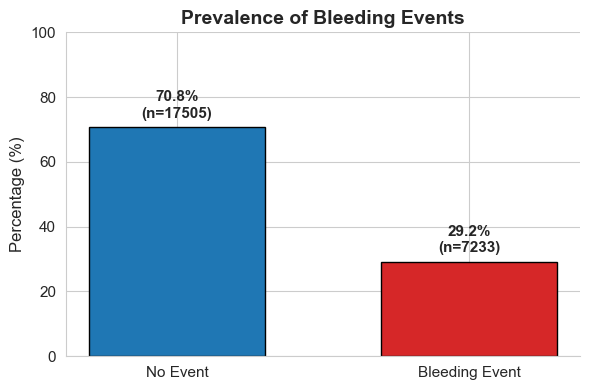

,Count,Percentage
bleeding_event,,
No Event,17505,70.76
Bleeding Event,7233,29.24


In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Professional style
sns.set_style("whitegrid")
plt.rcParams.update({
    "axes.titleweight": "bold",
    "axes.titlesize"  : 14,
    "axes.labelsize"  : 12,
    "xtick.labelsize" : 11,
    "ytick.labelsize" : 11
})

# --- Build frequency / percentage table ---
bleed_counts = df_imputed['bleeding_event'].value_counts().sort_index()
bleed_pct    = (bleed_counts / bleed_counts.sum() * 100).round(2)

pct_table = pd.DataFrame({
    'Count': bleed_counts,
    'Percentage': bleed_pct
}).rename(index={0: 'No Event', 1: 'Bleeding Event'})

# --- Professional bar plot ---
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(pct_table.index, pct_table['Percentage'],
              color=['#1f77b4', '#d62728'], edgecolor='black', width=0.6)

# Add value labels (% and count)
for bar, pct, cnt in zip(bars, pct_table['Percentage'], pct_table['Count']):
    ax.text(bar.get_x() + bar.get_width() / 2, pct + 2,
            f"{pct:.1f}%\n(n={cnt})", ha='center', va='bottom', fontsize=11, fontweight='bold')

# Formatting
ax.set_title("Prevalence of Bleeding Events")
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, 100)
ax.spines[['top', 'right']] .set_visible(False)

plt.tight_layout()
plt.show()

# Display underlying table
pct_table



In [108]:
print(df_imputed.columns.tolist())

['subject_id', 'hadm_id', 'bleeding_event', 'ALT_mean', 'AST_mean', 'Albumin_mean', 'BUN_mean', 'Calcium_mean', 'Creatinine_mean', 'D_dimer_mean', 'Fibrinogen_mean', 'Lactate_mean', 'Magnesium_mean', 'PT_mean', 'Platelets_mean', 'Potassium_mean', 'Sodium_mean', 'Total_Bilirubin_mean', 'ALT_min', 'AST_min', 'Albumin_min', 'BUN_min', 'Calcium_min', 'Creatinine_min', 'D_dimer_min', 'Fibrinogen_min', 'Lactate_min', 'Magnesium_min', 'PT_min', 'Platelets_min', 'Potassium_min', 'Sodium_min', 'Total_Bilirubin_min', 'ALT_max', 'AST_max', 'Albumin_max', 'BUN_max', 'Calcium_max', 'Creatinine_max', 'D_dimer_max', 'Fibrinogen_max', 'Lactate_max', 'Magnesium_max', 'PT_max', 'Platelets_max', 'Potassium_max', 'Sodium_max', 'Total_Bilirubin_max', 'ALT_std', 'AST_std', 'Albumin_std', 'BUN_std', 'Calcium_std', 'Creatinine_std', 'D_dimer_std', 'Fibrinogen_std', 'Lactate_std', 'Magnesium_std', 'PT_std', 'Platelets_std', 'Potassium_std', 'Sodium_std', 'Total_Bilirubin_std', 'amount', 'rate', 'Comorbidities_

# **Model Development

In [114]:
## **Step-Model Development:
## **Step-Model Evaluation:
## ** Step-Model Calibration:
## **Step-Interpretability:

LogReg: GridSearchCV
RF: GridSearchCV
XGB: GridSearchCV


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:43:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

LGBM: GridSearchCV
[LightGBM] [Info] Number of positive: 4628, number of negative: 11204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16230
[LightGBM] [Info] Number of data points in the train set: 15832, number of used features: 148
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292319 -> initscore=-0.884146
[LightGBM] [Info] Start training from score -0.884146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4629, number of negative: 11203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16236
[LightGBM] [Info] Number of data points in the train set: 15832, number of used features: 149
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292383 -> initscore=-0.883841
[LightGBM] [Info] Start training from score -0.883841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

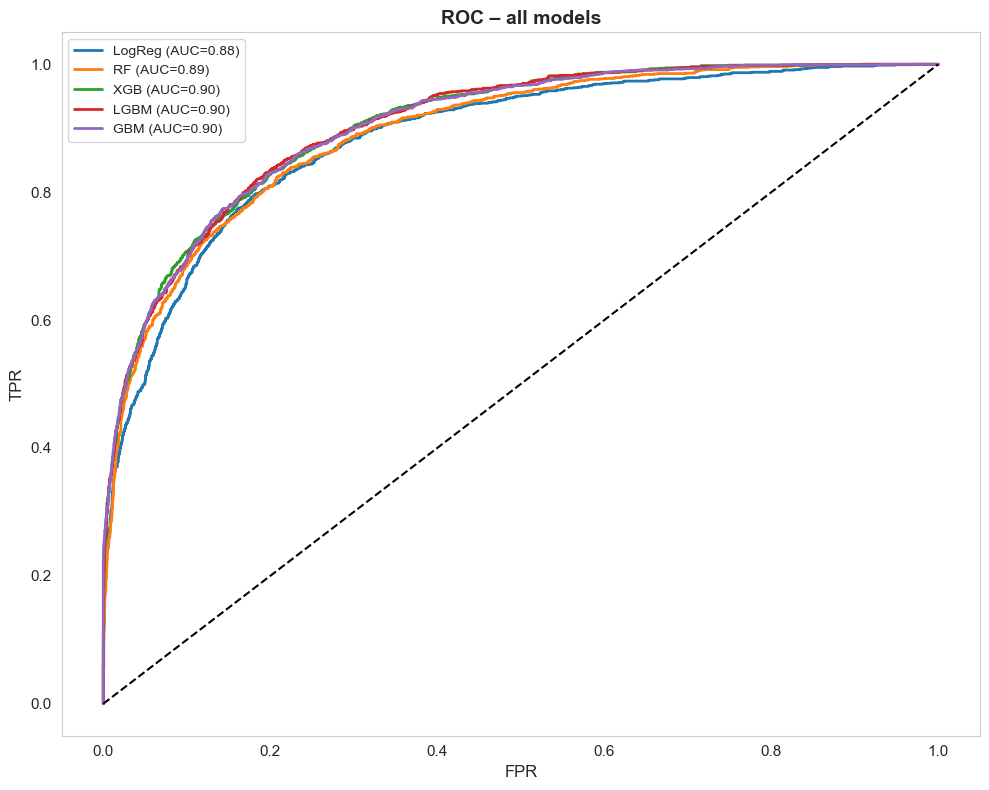

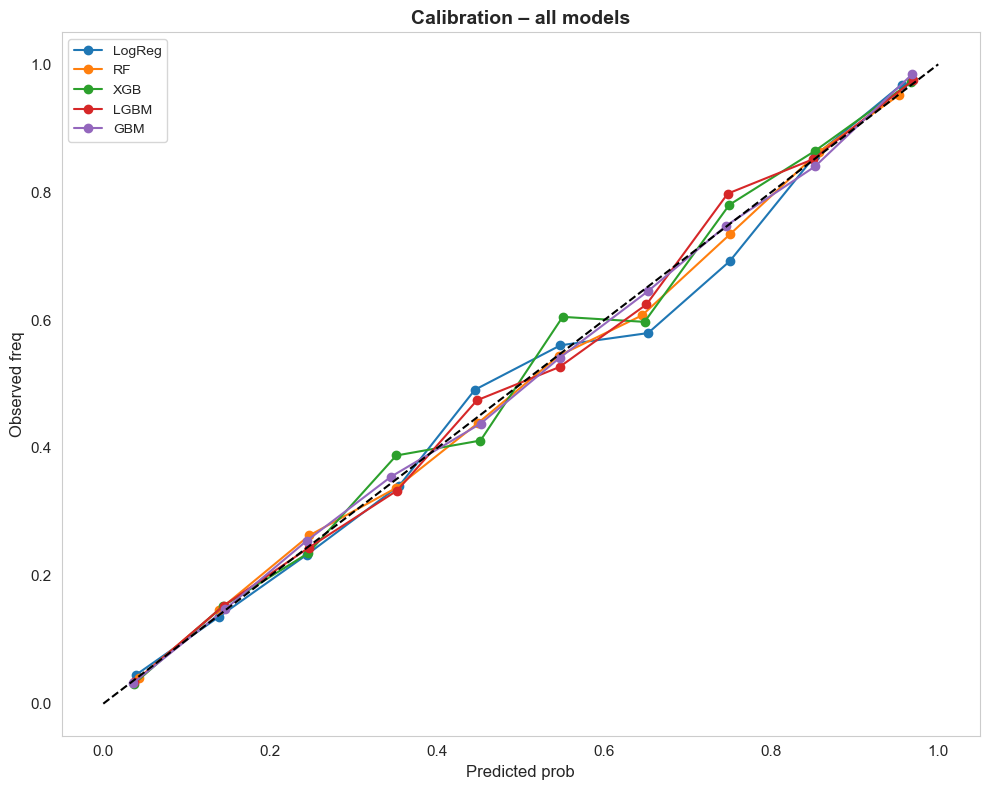

Model,ROC_AUC,Accuracy,F1,Sensitivity,Specificity,BestParams,Estimator
LGBM,0.905,0.844,0.709,0.650,0.924,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}","LGBMClassifier(max_depth=5, subsample=0.8)"
XGB,0.905,0.849,0.719,0.659,0.928,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}","XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.1, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=5, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)"
GBM,0.904,0.844,0.710,0.652,0.923,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}",GradientBoostingClassifier(n_estimators=200)
RF,0.893,0.839,0.696,0.630,0.926,"{'max_depth': 20, 'n_estimators': 200}","RandomForestClassifier(max_depth=20, n_estimators=200)"
LogReg,0.885,0.830,0.673,0.598,0.926,"{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}","LogisticRegression(C=0.1, max_iter=3000, solver='liblinear')"


Model,BestThreshold
LogReg,0.270000
RF,0.290000
XGB,0.240000
LGBM,0.250000
GBM,0.240000


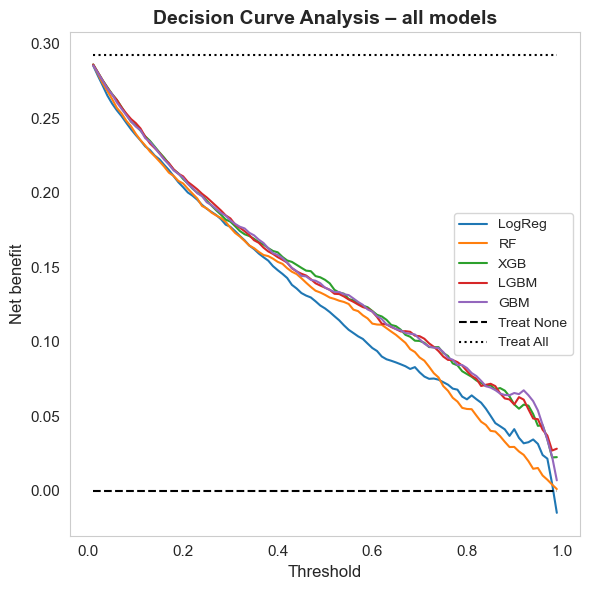

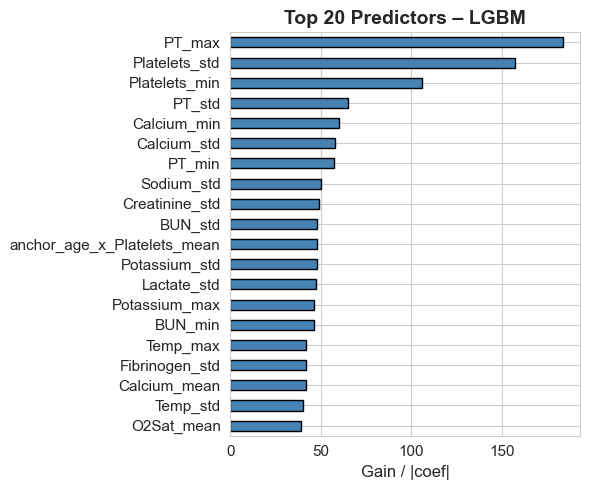

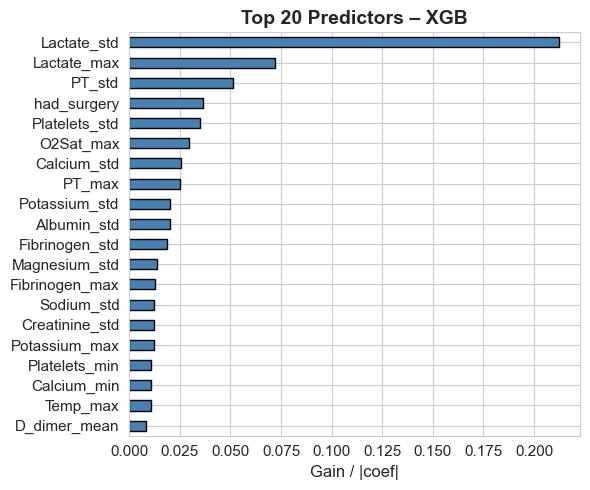

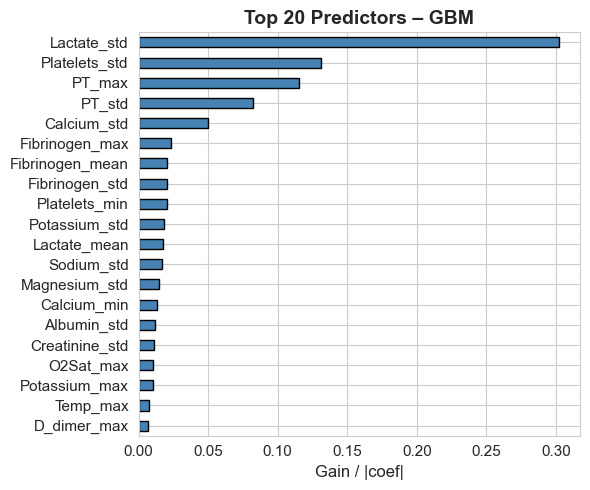

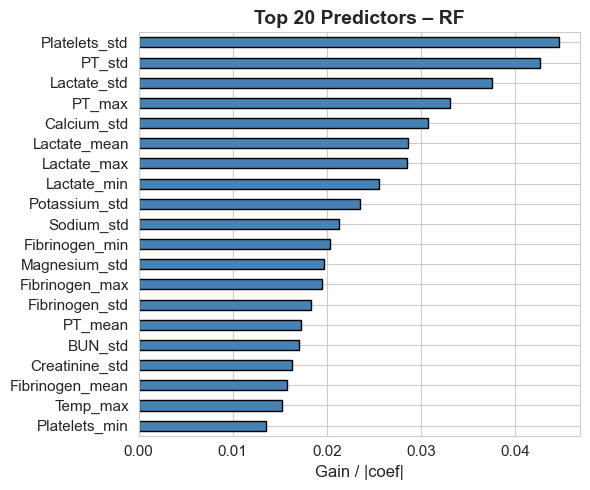

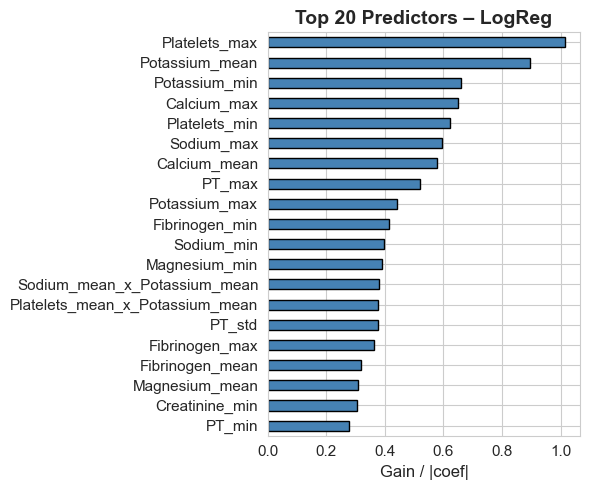

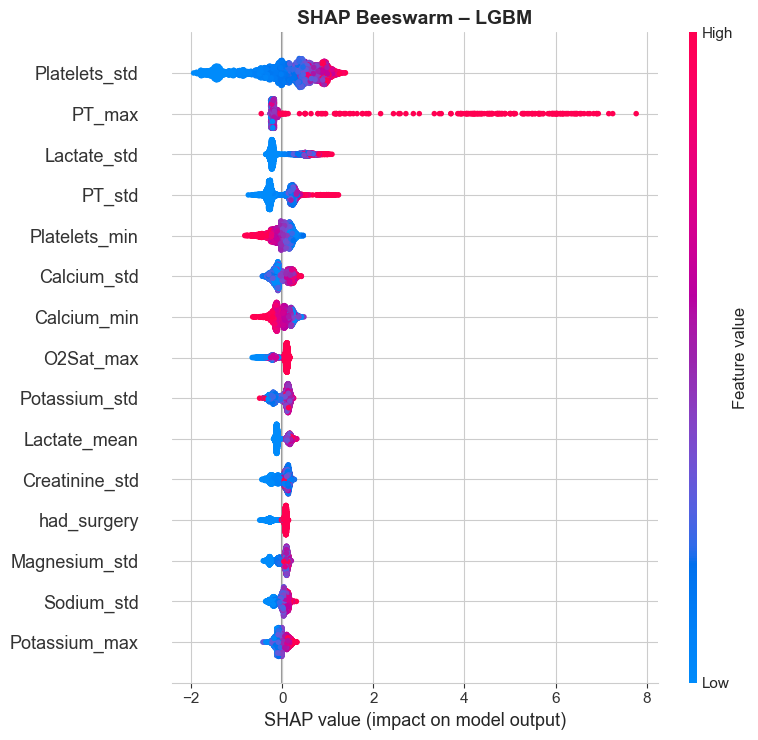

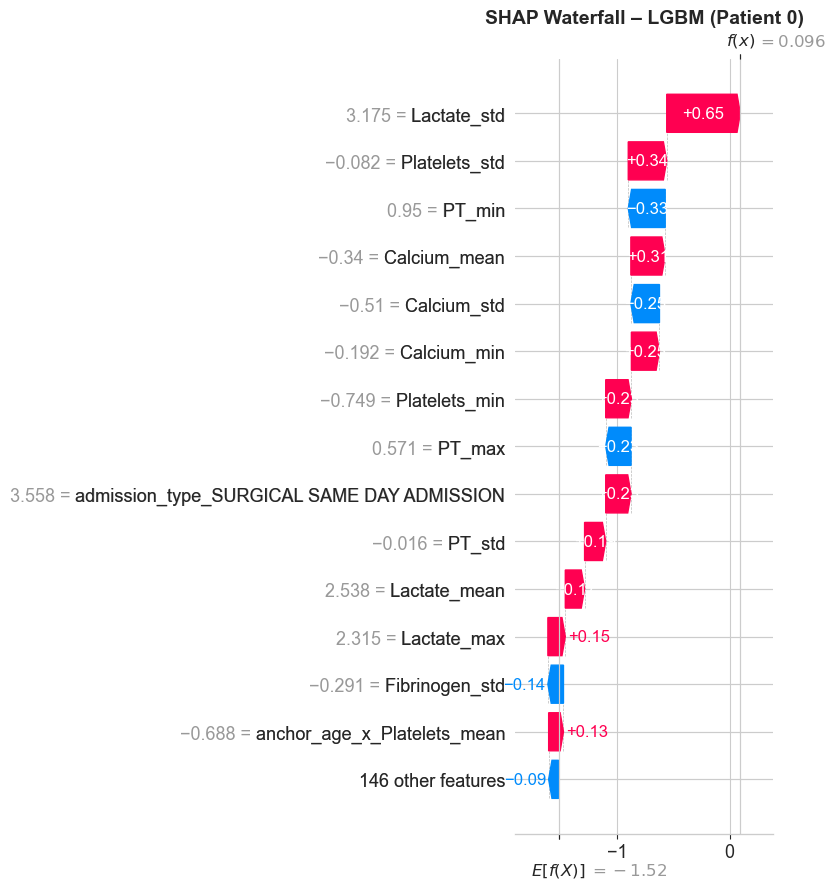

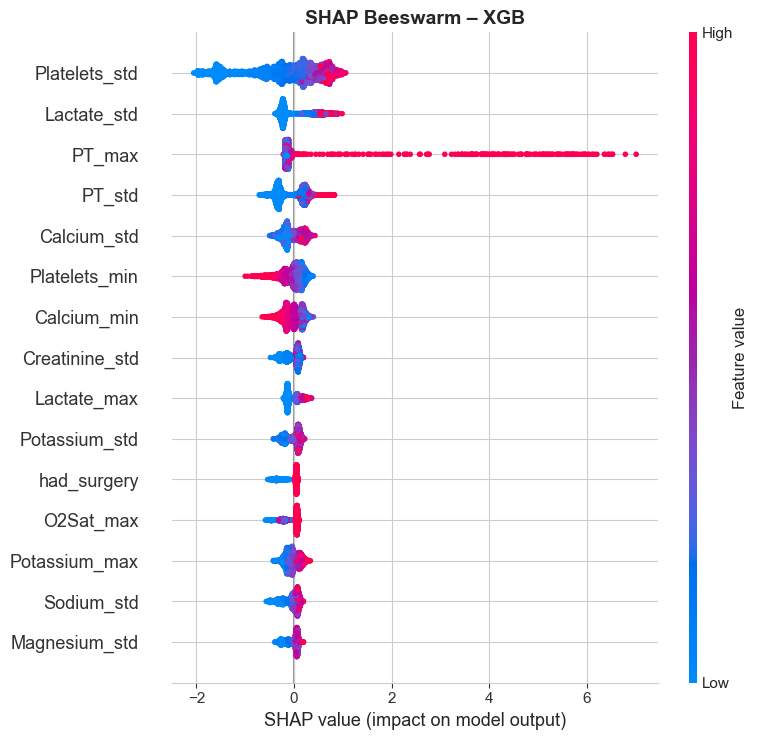

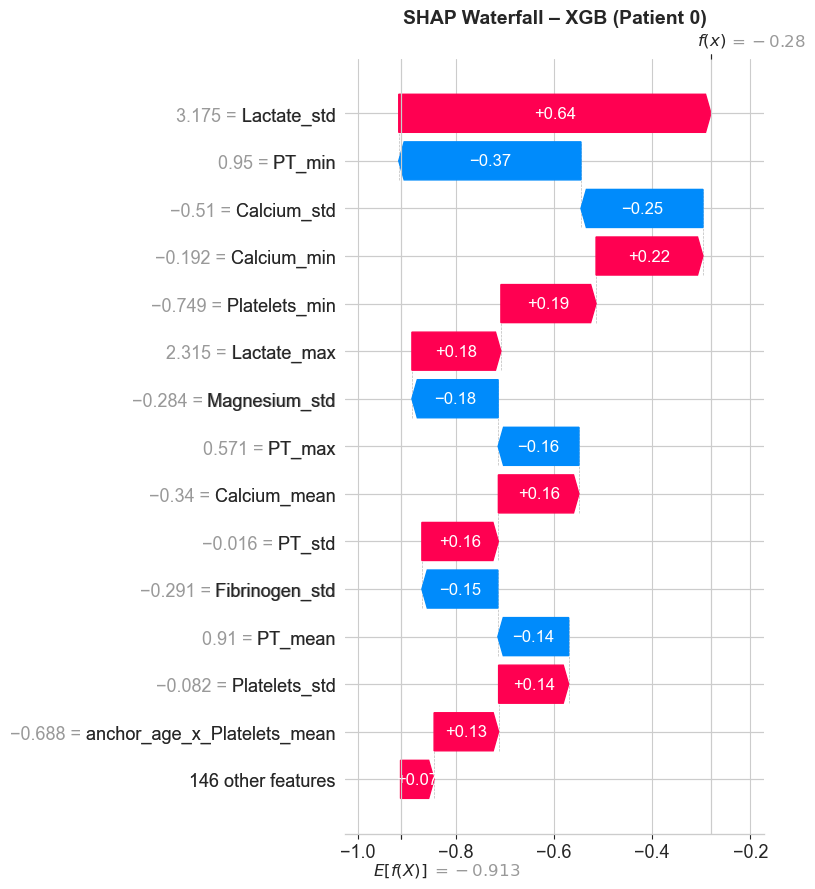

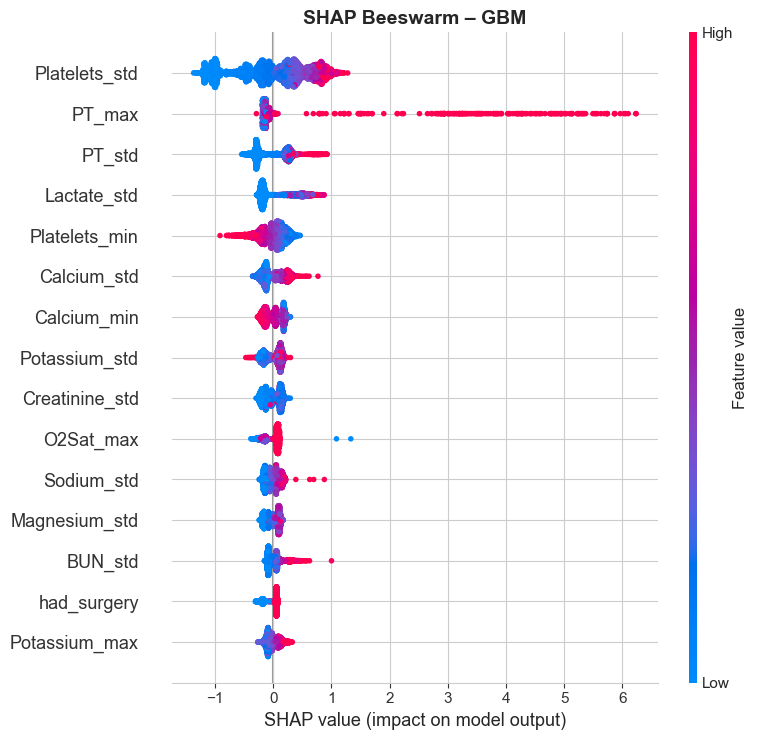

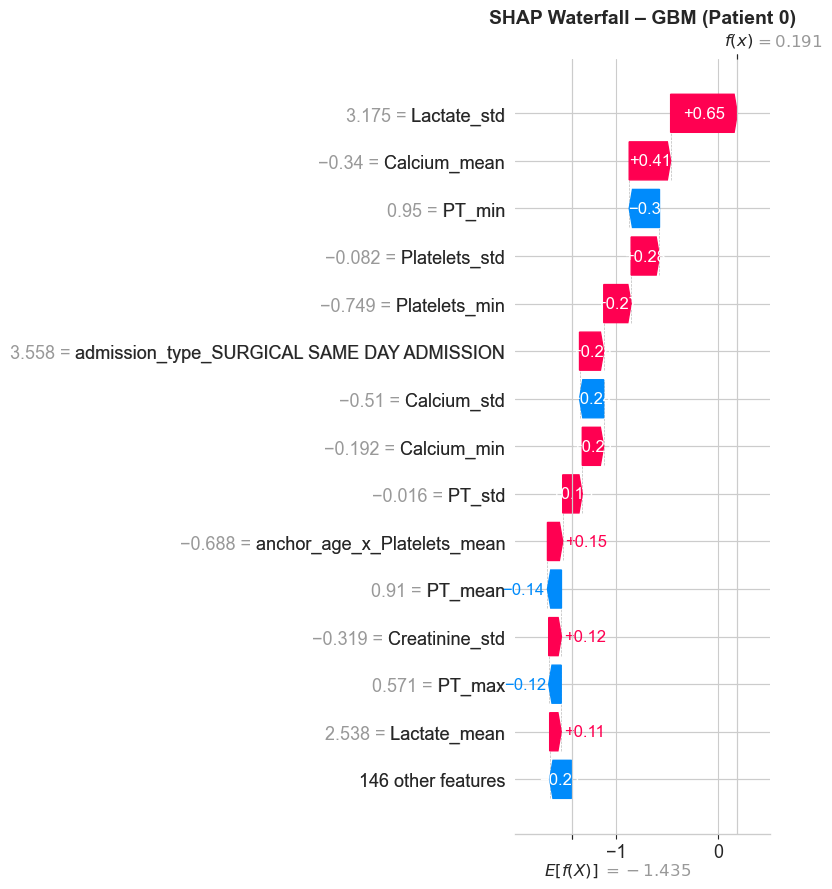

[LightGBM] [Info] Number of positive: 4629, number of negative: 11203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16228
[LightGBM] [Info] Number of data points in the train set: 15832, number of used features: 147
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292383 -> initscore=-0.883841
[LightGBM] [Info] Start training from score -0.883841
[LightGBM] [Info] Number of positive: 4629, number of negative: 11203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16219
[LightGBM] [Info] Number of data points in the train set: 15832, number of used features: 147
[LightGBM] [Info

<Figure size 640x480 with 0 Axes>

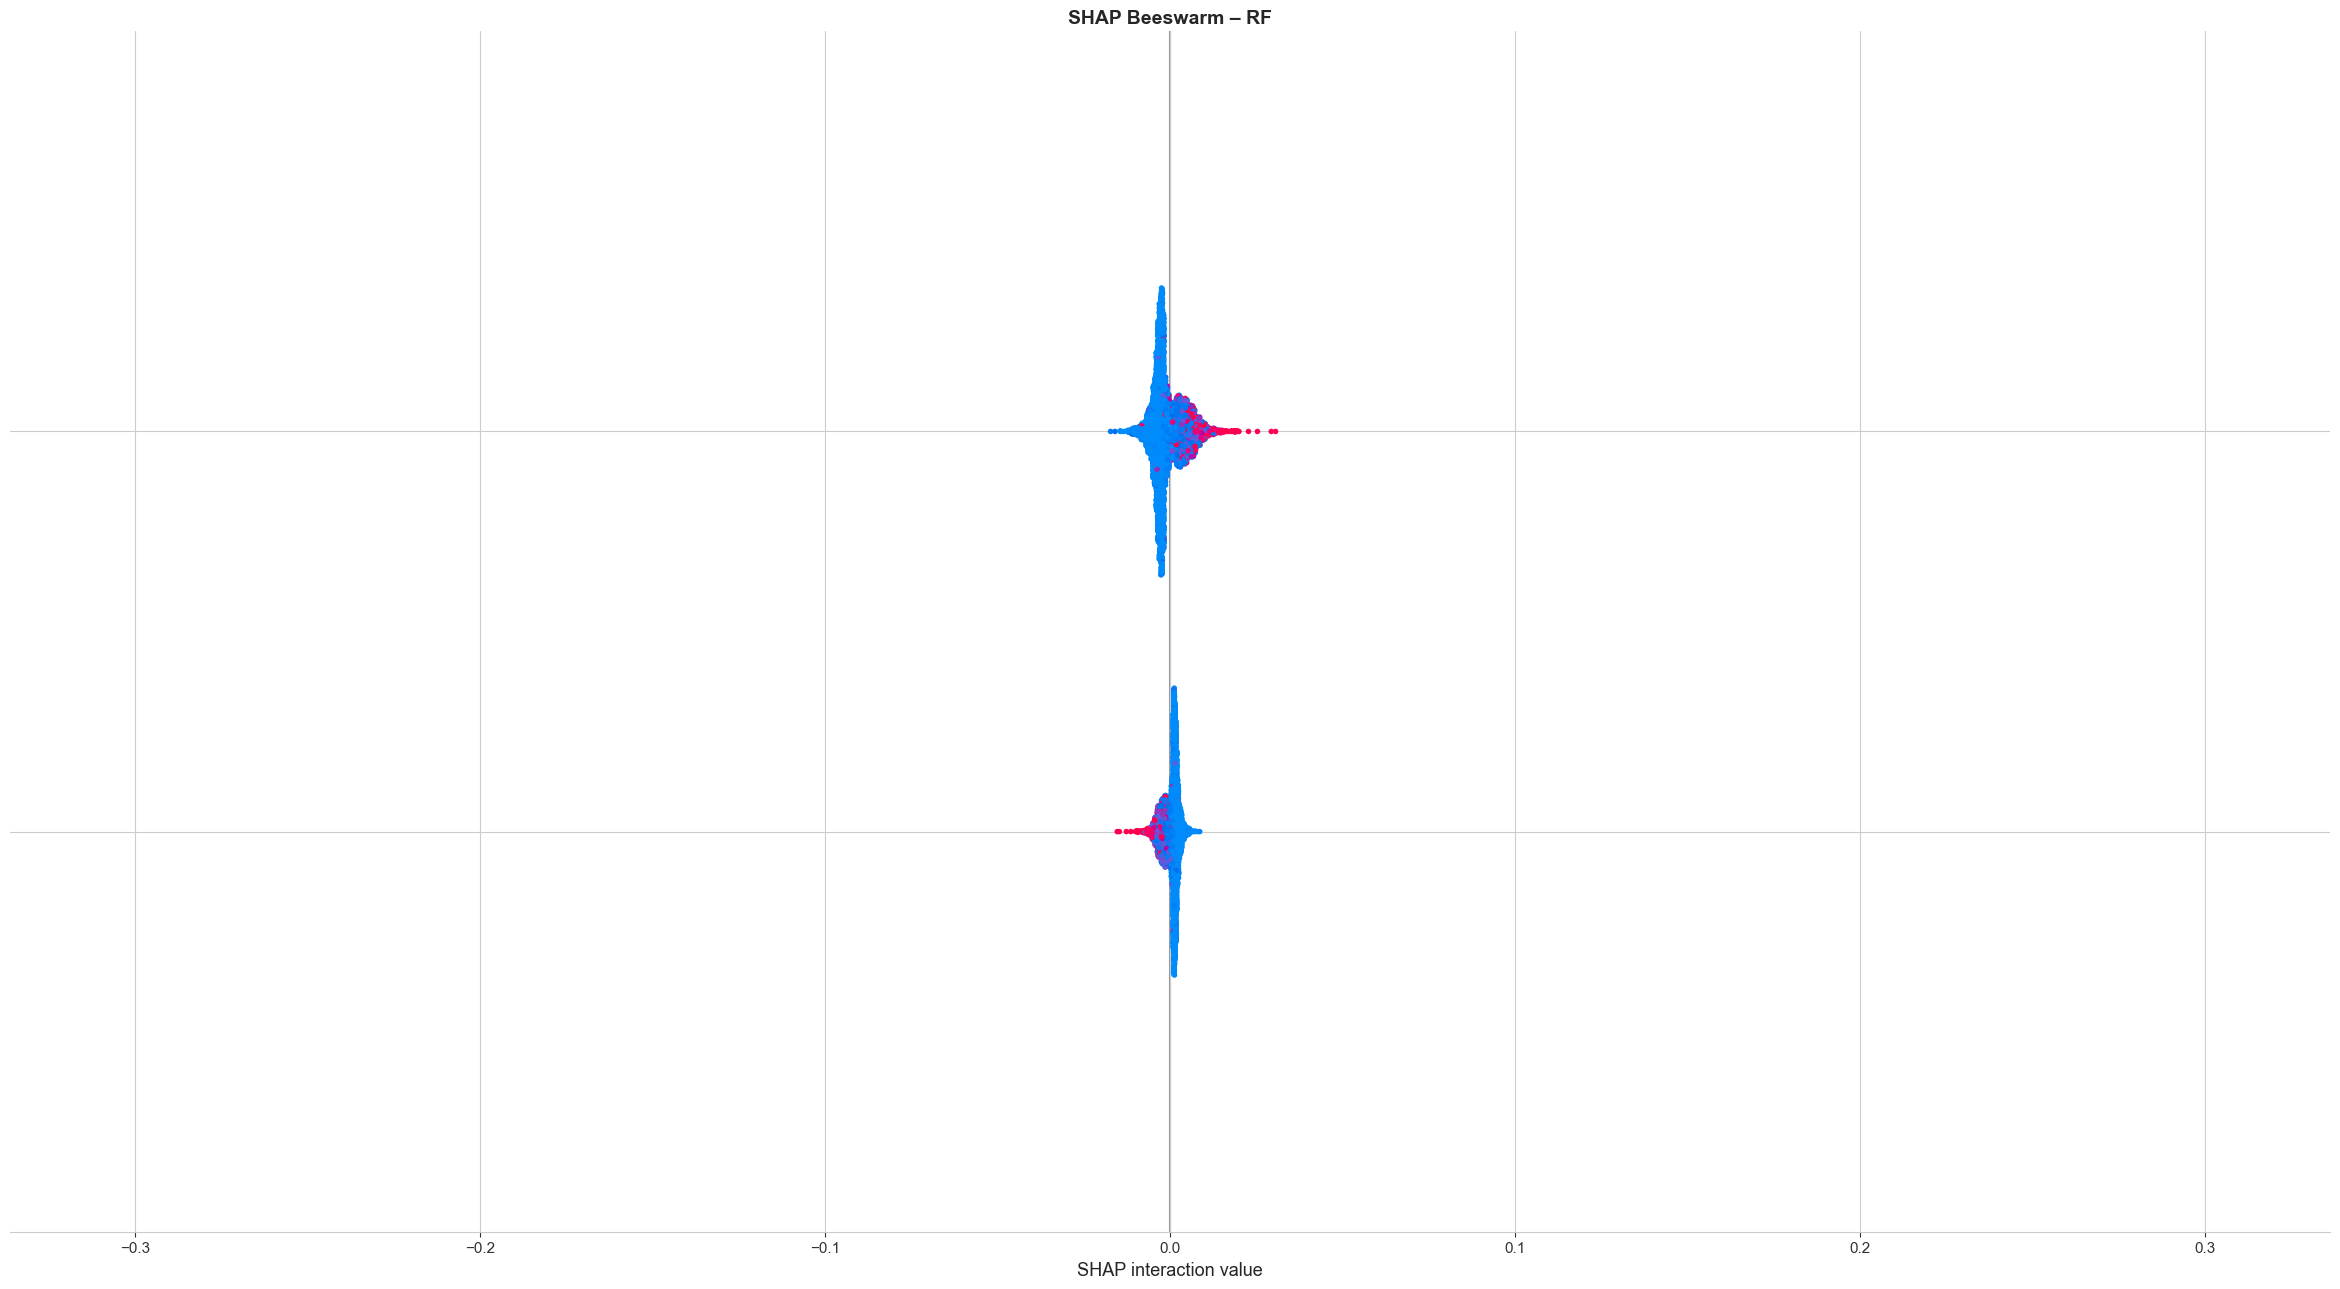

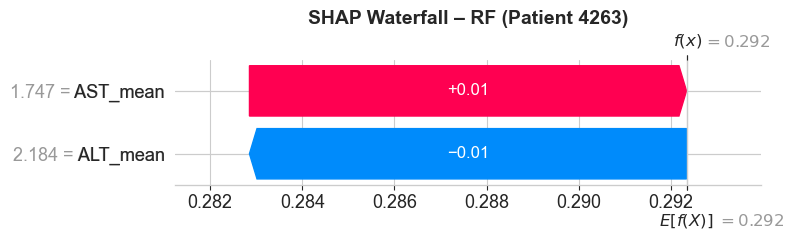

/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


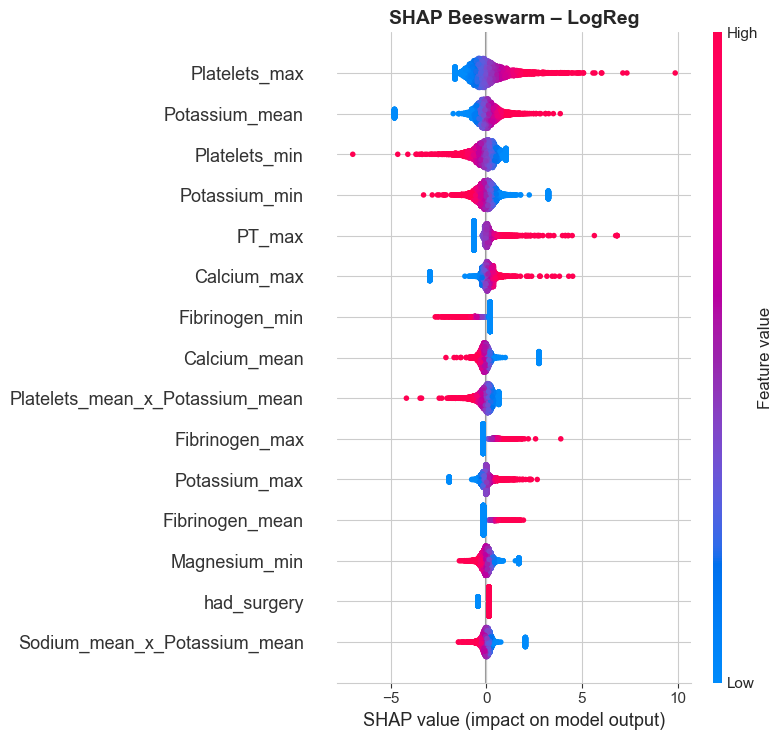

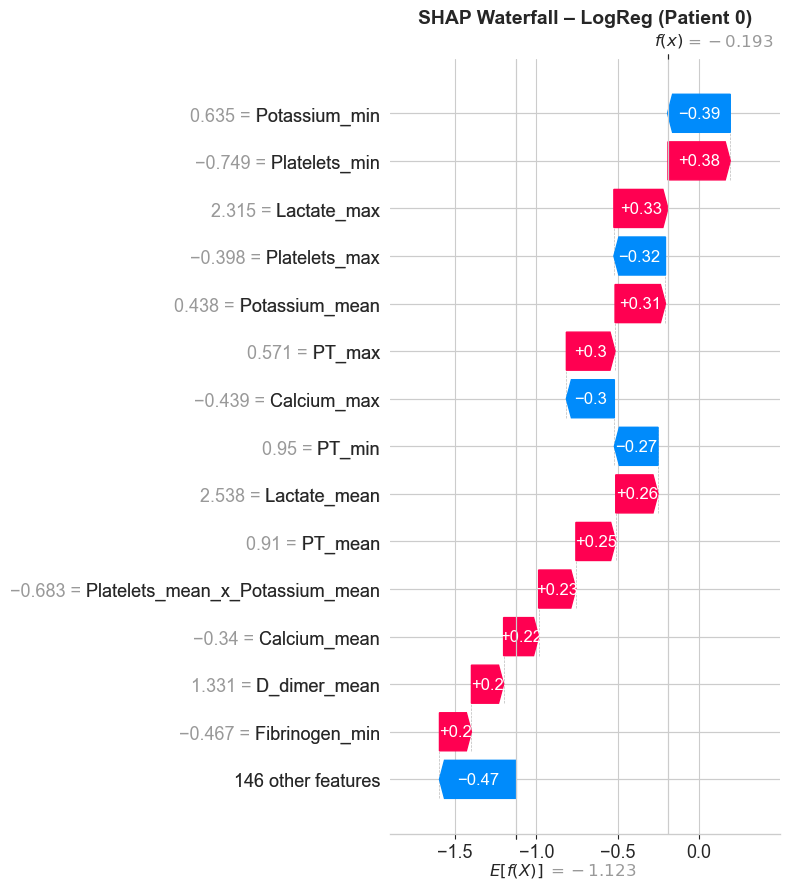

In [116]:
# 1 prepare the experiment 
exclude_cols = [
    'subject_id','hadm_id','bleeding_event','amount','rate','rateuom',
    'anchor_year','anchor_age','rateuom','amountuom','ordercategoryname',
    'ordercomponenttypedescription','heparin_start'
]
X_raw = df_imputed.drop(columns=exclude_cols)
y     = df_imputed['bleeding_event'].astype(int)

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_tr, X_te, y_tr, y_te = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 2 MODEL GRID: Shyperparameter optimization
models = {
    'LogReg': (LogisticRegression(max_iter=3000),
               {'C':[0.01,0.1,1,10],'penalty':['l2'],'solver':['liblinear']}),
    'RF':    (RandomForestClassifier(),
              {'n_estimators':[100,200],'max_depth':[10,20]}),
    'XGB':   (XGBClassifier(use_label_encoder=False,eval_metric='logloss'),
              {'n_estimators':[100,200],'max_depth':[5,10],
               'learning_rate':[0.01,0.1],'subsample':[0.8,1.0]}),
    'LGBM':  (LGBMClassifier(),
              {'n_estimators':[100,200],'max_depth':[5,10],
               'learning_rate':[0.01,0.1],'subsample':[0.8,1.0]}),
    'GBM':   (GradientBoostingClassifier(),
              {'n_estimators':[100,200],'max_depth':[3,5],
               'learning_rate':[0.01,0.1],'subsample':[0.8,1.0]})
}

# containers
results, thresh_rows, dca_curves = [], [], []
palette = sns.color_palette("tab10", n_colors=len(models))
fig_roc, ax_roc = plt.subplots(figsize=(10,8))
fig_cal, ax_cal = plt.subplots(figsize=(10,8))

# 3 TRAIN, TUNE, METRICS, ROC, CALIBRATION, DCA

for i,(tag,(est,grid)) in enumerate(models.items()):
    print(f"{tag}: GridSearchCV")
    gs   = GridSearchCV(est, grid, cv=5, scoring='roc_auc', n_jobs=-1)
    gs.fit(X_tr, y_tr)
    best = gs.best_estimator_

    proba = best.predict_proba(X_te)[:,1]
    pred  = (proba>=0.5).astype(int)

    roc   = roc_auc_score(y_te, proba)
    acc   = accuracy_score(y_te, pred)
    f1    = f1_score(y_te, pred)
    sens  = recall_score(y_te, pred)
    tn,fp,fn,tp = confusion_matrix(y_te, pred).ravel()
    spec  = tn/(tn+fp)
    results.append([tag, roc, acc, f1, sens, spec, gs.best_params_, best])

    # ROC curve
    fpr,tpr,_ = roc_curve(y_te, proba)
    ax_roc.plot(fpr,tpr,color=palette[i],lw=2,label=f"{tag} (AUC={roc:.2f})")

    # calibration
    calib = CalibratedClassifierCV(best,method='isotonic',cv=5).fit(X_tr,y_tr)
    o,e = calibration_curve(y_te, calib.predict_proba(X_te)[:,1], n_bins=10)
    ax_cal.plot(e,o,'o-',color=palette[i],label=tag)

    # Youden J threshold
    js = [(((proba>=t)&(y_te==1)).sum()/y_te.sum()
           +((proba< t)&(y_te==0)).sum()/(len(y_te)-y_te.sum()) -1 , t)
           for t in np.linspace(0,1,101)]
    thresh_rows.append([tag, max(js)[1]])

    # DCA
    pts = np.linspace(0.01,0.99,99)
    net = [((proba>=p)&(y_te==1)).sum()/len(y_te)
           -((proba>=p)&(y_te==0)).sum()/len(y_te)*p/(1-p) for p in pts]
    dca_curves.append((tag,pts,net,palette[i]))

# finish ROC & calibration figs
ax_roc.plot([0,1],[0,1],'k--'); ax_roc.set(xlabel="FPR",ylabel="TPR",title="ROC – all models")
ax_roc.legend(); ax_roc.grid(); fig_roc.tight_layout()
ax_cal.plot([0,1],[0,1],'k--'); ax_cal.set(xlabel="Predicted prob",ylabel="Observed freq",
                                           title="Calibration – all models")
ax_cal.legend(); ax_cal.grid(); fig_cal.tight_layout(); plt.show()

# tables
metrics_df = (pd.DataFrame(results, columns=[
        'Model','ROC_AUC','Accuracy','F1','Sensitivity','Specificity','BestParams','Estimator'
     ]).sort_values('ROC_AUC',ascending=False).reset_index(drop=True))
thresholds_df = pd.DataFrame(thresh_rows, columns=['Model','BestThreshold'])

display(metrics_df.style.format('{:.3f}', subset=metrics_df.columns[1:6]).hide(axis='index'))
display(thresholds_df.style.hide(axis='index'))

# decision curve
plt.figure(figsize=(6,6))
for tag,pts,net,col in dca_curves:
    plt.plot(pts,net,color=col,label=tag)
plt.plot(pts,[0]*len(pts),'k--',label='Treat None')
plt.plot(pts,[y_te.mean()]*len(pts),'k:',label='Treat All')
plt.title("Decision Curve Analysis – all models"); plt.xlabel("Threshold"); plt.ylabel("Net benefit")
plt.legend(); plt.grid(); plt.tight_layout(); plt.show()


# TOP‑20 FEATURE IMPORTANCE  (per every model)
for row in metrics_df.itertuples():
    est, tag = row.Estimator, row.Model
    if hasattr(est,"feature_importances_"):
        imp = pd.Series(est.feature_importances_, index=X_raw.columns)\
                .sort_values(ascending=False).head(20)
    elif hasattr(est,"coef_"):
        imp = pd.Series(np.abs(est.coef_).ravel(), index=X_raw.columns)\
                .sort_values(ascending=False).head(20)
    else:
        continue
    imp.plot(kind='barh',figsize=(6,5),color='steelblue',edgecolor='black')
    plt.gca().invert_yaxis(); plt.title(f"Top 20 Predictors – {tag}")
    plt.xlabel("Gain / |coef|"); plt.tight_layout(); plt.show()


#  SHAP  –  GLOBAL & LOCAL  FOR *ALL* MODELS

%matplotlib inline     

import shap, matplotlib.pyplot as plt, numpy as np, warnings
from scipy.special import expit
warnings.filterwarnings("ignore", message=".*shap values output has changed.*")
shap.initjs()

# ---- SHAP Explanation Function ----
def explain_model(est, X_test, feat_names, mdl_name,
                  max_display=15, min_impact=0.02):

    # Choose explainer type
    if hasattr(est, "feature_importances_"):
        explainer = shap.TreeExplainer(est)
        sv = explainer.shap_values(X_test, check_additivity=False)
        sv = sv[1] if isinstance(sv, list) else sv
    elif hasattr(est, "coef_"):
        explainer = shap.LinearExplainer(est, X_test, feature_perturbation="interventional")
        sv = explainer.shap_values(X_test)
    else:
        print(f"(!) SHAP not supported for {mdl_name}")
        return

    # GLOBAL: SHAP Beeswarm Plot
    shap.summary_plot(sv, X_test, feature_names=feat_names,
                      max_display=max_display, show=False)
    plt.title(f"SHAP Beeswarm – {mdl_name}")
    plt.tight_layout()
    plt.show()

    # LOCAL: SHAP Waterfall Plot (1 patient)
    if sv.ndim == 3:
        sv_pos = sv[:, 1, :] if sv.shape[1] > 1 else sv[:, 0, :]
    else:
        sv_pos = sv

    impacts = np.abs(sv_pos).sum(axis=1)
    idx = int(np.where(impacts >= min_impact)[0][0]) if (impacts >= min_impact).any() else impacts.argmax()

    base_val = explainer.expected_value
    if isinstance(base_val, (list, np.ndarray)):
        base_val = base_val[-1]

    shap.plots.waterfall(
        shap.Explanation(values        = sv_pos[idx],
                         base_values   = base_val,
                         data          = X_test[idx],
                         feature_names = feat_names),
        max_display=max_display, show=False)
    plt.title(f"SHAP Waterfall – {mdl_name} (Patient {idx})")
    plt.tight_layout()
    plt.show()

# ---- Run for All Models in metrics_df ----
for mdl_name, est in zip(metrics_df["Model"], metrics_df["Estimator"]):
    explain_model(est, X_te, X_raw.columns, mdl_name)


In [150]:
explainer = shap.LinearExplainer(est, X_te, feature_perturbation="interventional")
sv = explainer.shap_values(X_te)
shap_values_mean = np.abs(sv).mean(axis=0)
top_features = pd.Series(shap_values_mean, index=X_raw.columns).sort_values(ascending=False)
print(top_features.head(20))

Platelets_max                      0.847092
Platelets_min                      0.535432
Potassium_mean                     0.502376
Potassium_min                      0.419712
Platelets_mean_x_Potassium_mean    0.402335
Calcium_max                        0.364817
Fibrinogen_mean                    0.313681
Fibrinogen_min                     0.294328
PT_max                             0.256039
PT_mean                            0.247146
Potassium_max                      0.241623
Calcium_min                        0.224459
PT_min                             0.221193
Calcium_mean                       0.219105
had_surgery                        0.200867
Magnesium_min                      0.193607
Sodium_max                         0.186147
Potassium_std                      0.183943
BUN_mean                           0.177981
Albumin_max                        0.175500
dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


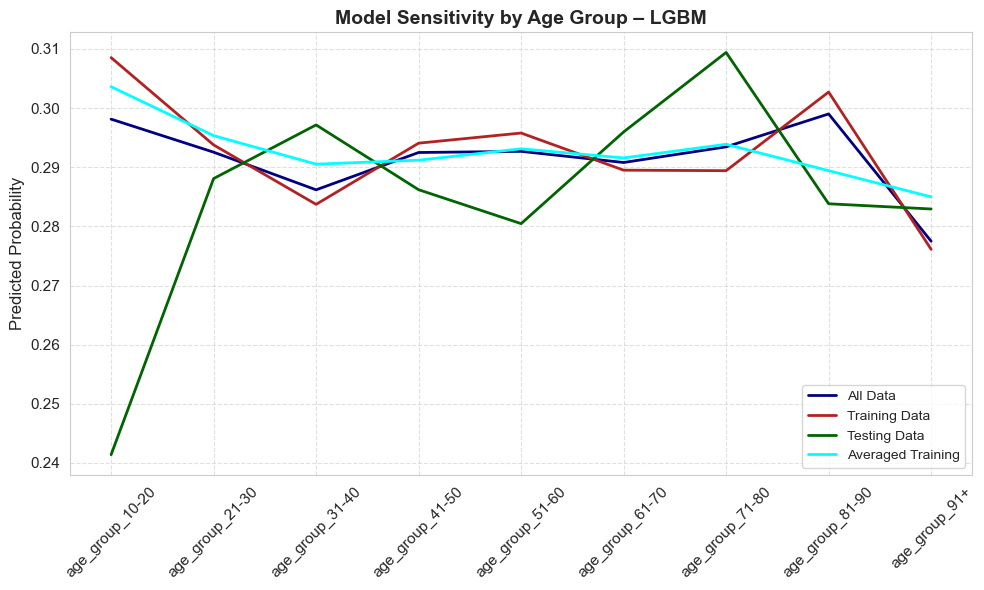

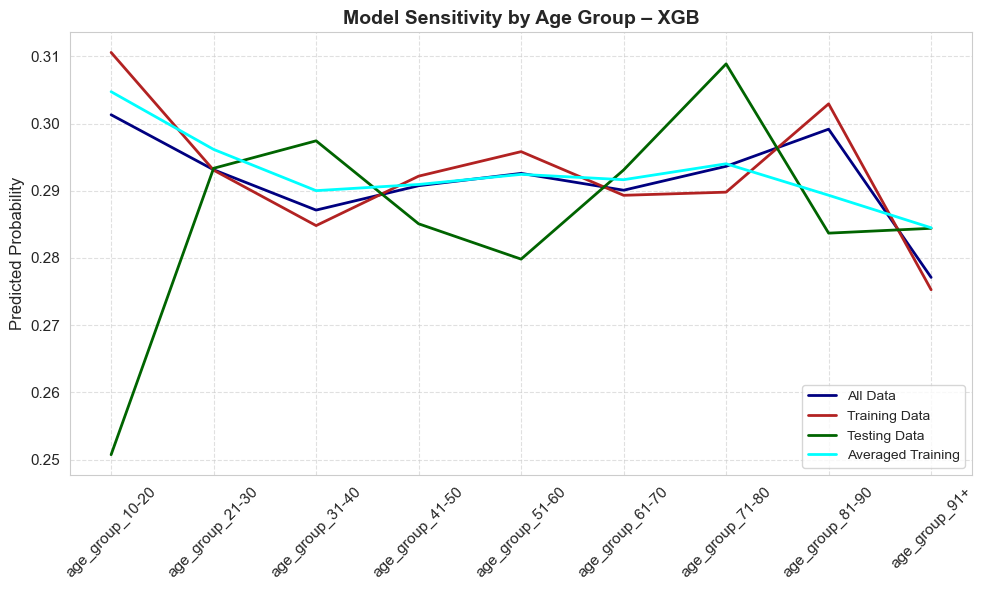

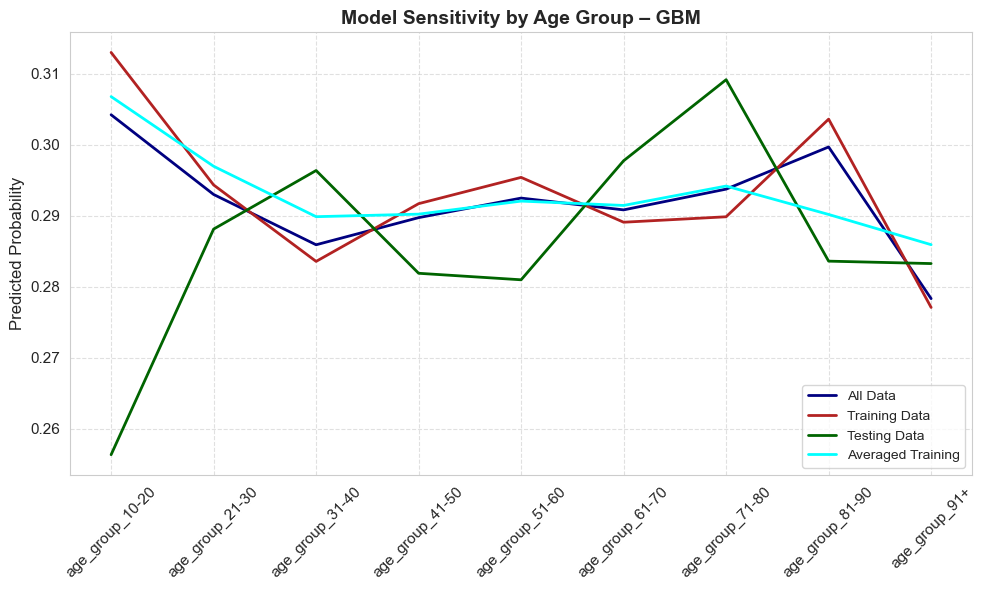

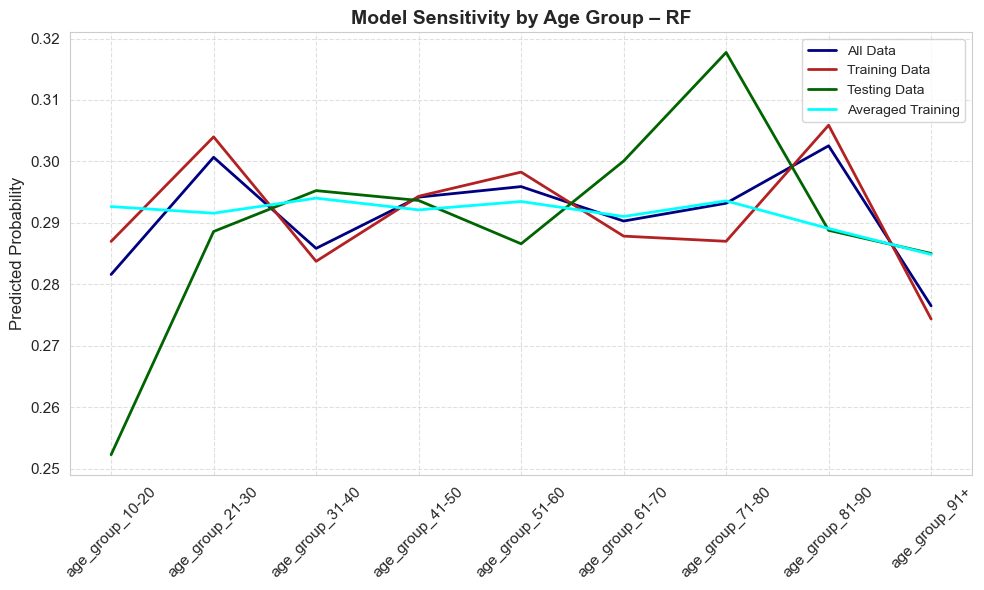

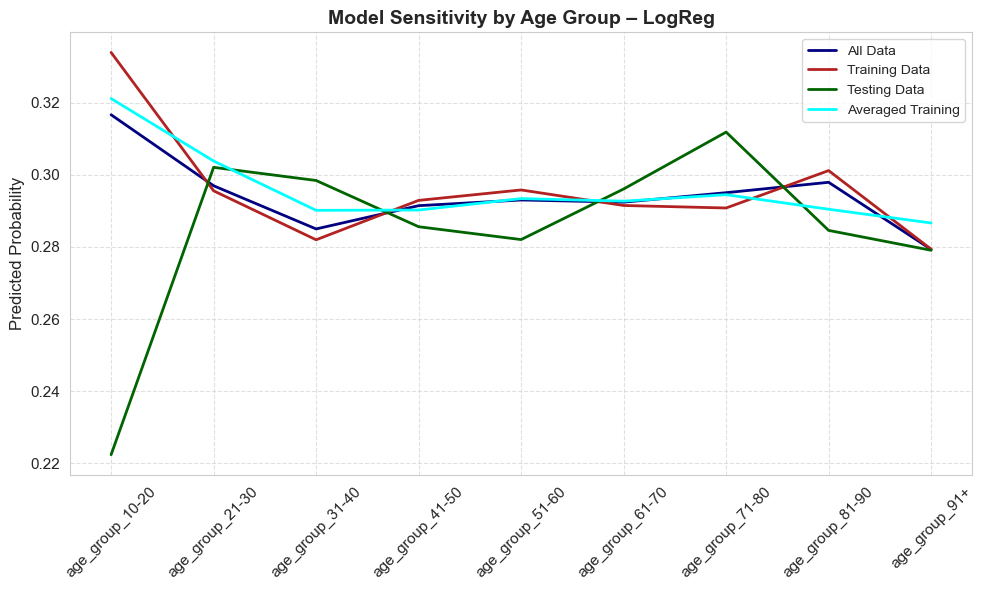

In [144]:
##Global Sensitivity Analysis
# Define age group columns
age_cols = [col for col in df_imputed.columns if col.startswith('age_group_')]

# Split data
df_train = df_imputed.iloc[:X_tr.shape[0]].copy()
df_test  = df_imputed.iloc[X_tr.shape[0]:].copy()

# Loop through each model
for model_name, model in zip(metrics_df['Model'], metrics_df['Estimator']):
    # Predict probabilities
    df_imputed['y_prob'] = model.predict_proba(np.vstack([X_tr, X_te]))[:, 1]
    df_train['y_prob'] = model.predict_proba(X_tr)[:, 1]
    df_test['y_prob'] = model.predict_proba(X_te)[:, 1]

    # Initialize storage
    all_data = {}
    train_data = {}
    test_data = {}

    for col in age_cols:
        all_data[col] = df_imputed[df_imputed[col] == 1]['y_prob'].mean()
        train_data[col] = df_train[df_train[col] == 1]['y_prob'].mean()
        test_data[col] = df_test[df_test[col] == 1]['y_prob'].mean()

    # Sort age groups
    def sort_key(col):
        try:
            return int(col.split('_')[-1].split('-')[0])
        except:
            return 999

    sorted_cols = sorted(age_cols, key=sort_key)
    x_labels = sorted_cols
    all_vals = [all_data[col] for col in sorted_cols]
    train_vals = [train_data[col] for col in sorted_cols]
    test_vals = [test_data[col] for col in sorted_cols]

    # Smoothed version of training data (rolling average)
    from scipy.ndimage import uniform_filter1d
    avg_train_vals = uniform_filter1d(train_vals, size=3, mode='nearest')

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_labels, all_vals, label='All Data', color='navy', linewidth=2)
    plt.plot(x_labels, train_vals, label='Training Data', color='firebrick', linewidth=2)
    plt.plot(x_labels, test_vals, label='Testing Data', color='darkgreen', linewidth=2)
    plt.plot(x_labels, avg_train_vals, label='Averaged Training', color='cyan', linewidth=2)

    plt.xticks(rotation=45)
    plt.ylabel("Predicted Probability")
    plt.title(f"Model Sensitivity by Age Group – {model_name}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



── Threshold sweep for LGBM


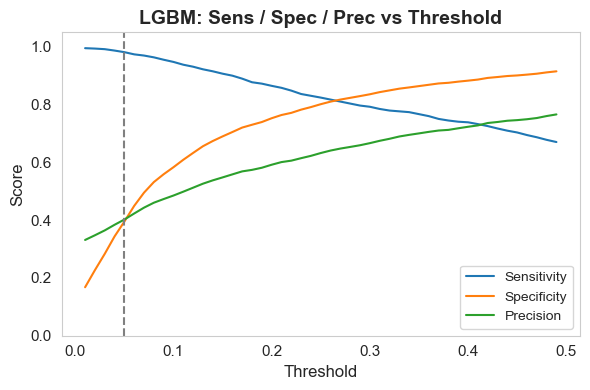


── Threshold sweep for XGB


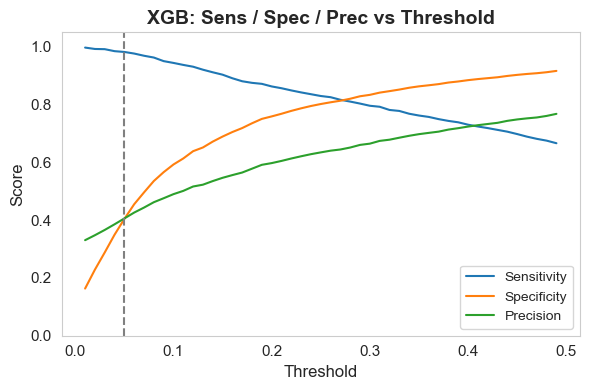


── Threshold sweep for GBM


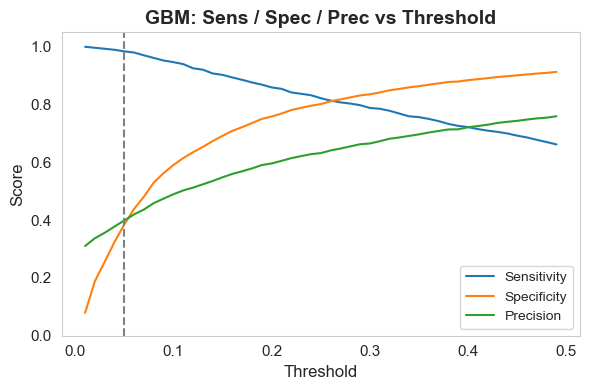


── Threshold sweep for RF


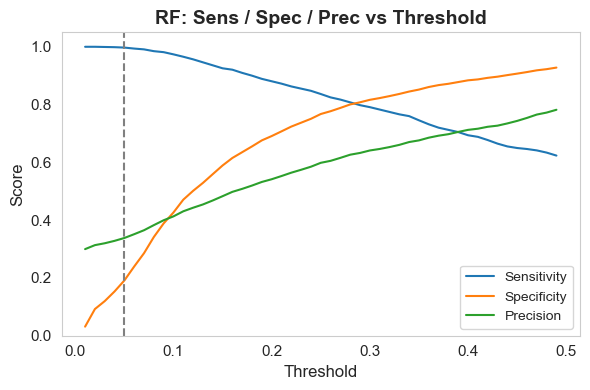


── Threshold sweep for LogReg


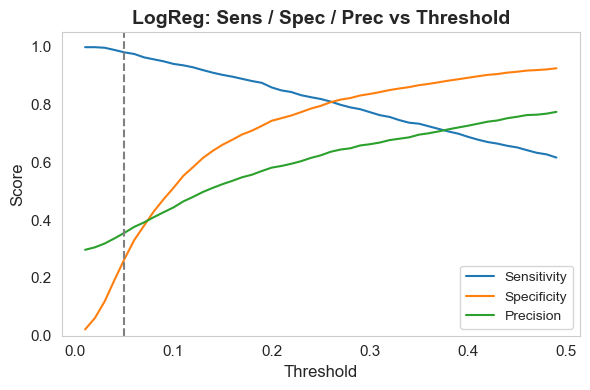

Model,ROC_AUC,Accuracy,F1,Sensitivity,Specificity,BestParams,Estimator
LGBM,0.902,0.842,0.710,0.660,0.918,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}","LGBMClassifier(max_depth=5, subsample=0.8)"
XGB,0.902,0.843,0.710,0.657,0.920,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}","XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.1, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=5, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)"
GBM,0.901,0.842,0.708,0.656,0.919,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}",GradientBoostingClassifier(n_estimators=200)
RF,0.890,0.839,0.691,0.614,0.932,"{'max_depth': 10, 'n_estimators': 200}","RandomForestClassifier(max_depth=10, n_estimators=200)"
LogReg,0.885,0.834,0.682,0.606,0.929,"{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}","LogisticRegression(C=0.1, max_iter=3000, solver='liblinear')"


Model,BestThreshold
LogReg,0.260000
RF,0.280000
XGB,0.310000
LGBM,0.340000
GBM,0.290000


Model,Train_AUC,Test_AUC
LGBM,0.946,0.902
XGB,0.945,0.902
GBM,0.930,0.901
RF,0.953,0.890
LogReg,0.894,0.885


In [152]:
#  THRESHOLD SWEEP  (all models) 
thresholds  = np.arange(0.01, 0.5, 0.01)
thresh_dict = {}                    
auc_rows    = []                     

for mdl_name, est in zip(metrics_df['Model'], metrics_df['Estimator']):
    print(f"\n── Threshold sweep for {mdl_name}")
    y_test_prob  = est.predict_proba(X_te)[:, 1]
    y_train_prob = est.predict_proba(X_tr)[:, 1]
    sweep_rows   = []

    # loop through thresholds
    for t in thresholds:
        y_pred = (y_test_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
        sens = tp / (tp + fn) if (tp + fn) else 0
        spec = tn / (tn + fp) if (tn + fp) else 0
        prec = tp / (tp + fp) if (tp + fp) else 0
        sweep_rows.append([t, sens, spec, prec, tp, fp, fn, tn])

    df_t = pd.DataFrame(sweep_rows, columns=[
        "Threshold", "Sensitivity", "Specificity",
        "Precision", "TP", "FP", "FN", "TN"
    ])
    thresh_dict[mdl_name] = df_t

    # ----- plot curve -----
    plt.figure(figsize=(6,4))
    plt.plot(df_t['Threshold'], df_t['Sensitivity'],  label='Sensitivity')
    plt.plot(df_t['Threshold'], df_t['Specificity'],  label='Specificity')
    plt.plot(df_t['Threshold'], df_t['Precision'],    label='Precision')
    plt.axvline(0.05, ls='--', c='grey')
    plt.title(f"{mdl_name}: Sens / Spec / Prec vs Threshold")
    plt.xlabel("Threshold"); plt.ylabel("Score")
    plt.ylim(0,1.05); plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

    # ----- Youden‑J best threshold -----
    df_t['YoudenJ'] = df_t['Sensitivity'] + df_t['Specificity'] - 1
    best_row = df_t.loc[df_t['YoudenJ'].idxmax()]
    thresholds_df.loc[len(thresholds_df)] = [mdl_name, best_row['Threshold']]

    # ----- AUC gap ( to check if over‑fit ?) -----
    auc_rows.append([mdl_name,
                     roc_auc_score(y_tr, y_train_prob),
                     roc_auc_score(y_te, y_test_prob)])


#  DISPLAY TABLES 

num_cols = metrics_df.select_dtypes(include=[np.number]).columns

display(
    metrics_df.style
       .format('{:.3f}', subset=num_cols)  
       .hide(axis='index')
)

display(
    thresholds_df.drop_duplicates('Model')
       .style.hide(axis='index')
)

auc_df = pd.DataFrame(auc_rows, columns=['Model','Train_AUC','Test_AUC'])
display(auc_df.style.format({'Train_AUC':'{:.3f}','Test_AUC':'{:.3f}'})
                .hide(axis='index'))



Fixed Threshold (0.05)


Model,Threshold,Flagged,Total,FP,TN,TP,FN,Sensitivity,Precision
LGBM,0.05,3539,4948,2116,1382,1423,27,0.981,0.402
XGB,0.05,3508,4948,2084,1414,1424,26,0.982,0.406
GBM,0.05,3576,4948,2149,1349,1427,23,0.984,0.399
RF,0.05,4275,4948,2829,669,1446,4,0.997,0.338
LogReg,0.05,3994,4948,2572,926,1422,28,0.981,0.356


Optimal Threshold (per model)


Model,Threshold,Flagged,Total,FP,TN,TP,FN,Sensitivity,Precision
LGBM,0.34,1614,4948,492,3006,1122,328,0.774,0.695
XGB,0.31,1704,4948,555,2943,1149,301,0.792,0.674
GBM,0.29,1746,4948,589,2909,1157,293,0.798,0.663
RF,0.28,1869,4948,698,2800,1171,279,0.808,0.627
LogReg,0.26,1846,4948,671,2827,1175,275,0.810,0.637


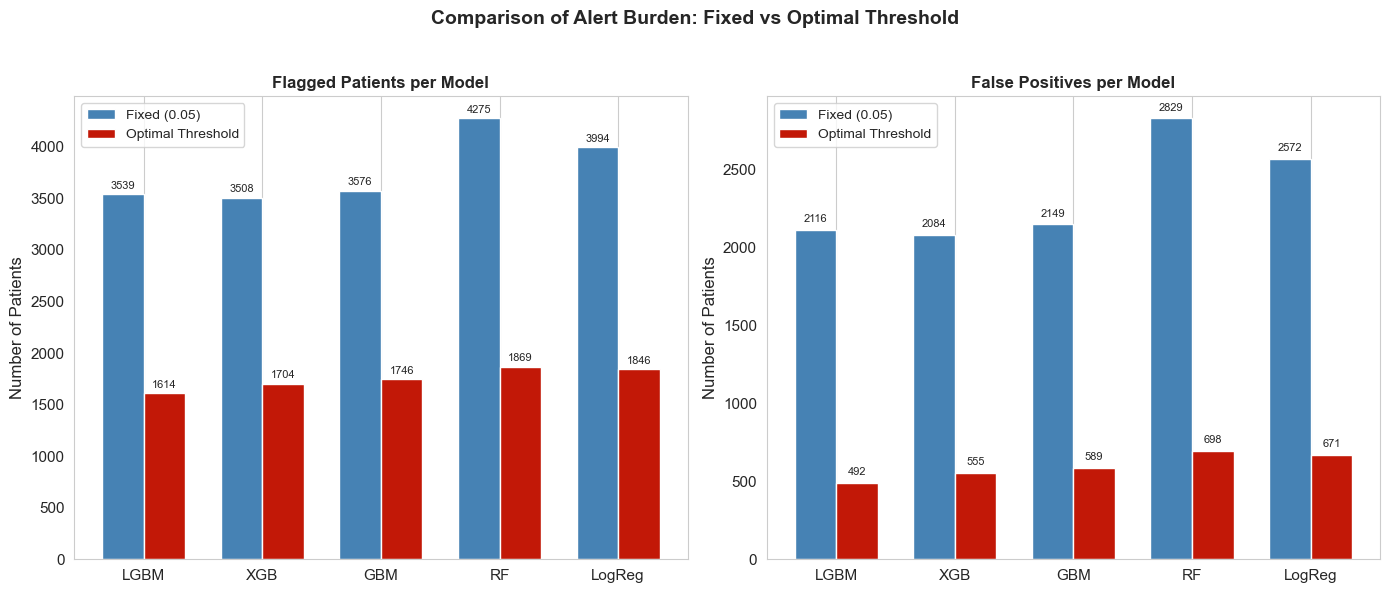

In [158]:


#Generate Summary Tables
summary_fixed = []
summary_optimal = []

for mdl_name, est in zip(metrics_df['Model'], metrics_df['Estimator']):
    y_prob = est.predict_proba(X_te)[:, 1]

    df_thresh = thresh_dict[mdl_name].copy()
    df_thresh['YoudenJ'] = df_thresh['Sensitivity'] + df_thresh['Specificity'] - 1
    best_thresh = df_thresh.loc[df_thresh['YoudenJ'].idxmax(), 'Threshold']

    for label, threshold in [('Fixed', 0.05), ('Optimal', best_thresh)]:
        y_pred = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
        sens = tp / (tp + fn) if (tp + fn) else 0
        prec = tp / (tp + fp) if (tp + fp) else 0
        row = [mdl_name, round(threshold, 2), tp + fp, len(y_te),
               fp, tn, tp, fn, round(sens, 3), round(prec, 3)]
        if label == 'Fixed':
            summary_fixed.append(row)
        else:
            summary_optimal.append(row)

columns = ["Model", "Threshold", "Flagged", "Total", "FP", "TN", "TP", "FN", "Sensitivity", "Precision"]
df_fixed = pd.DataFrame(summary_fixed, columns=columns)
df_optimal = pd.DataFrame(summary_optimal, columns=columns)

# Step 2: Display Tables
print("Fixed Threshold (0.05)")
display(df_fixed.style.format({'Threshold':'{:.2f}', 'Sensitivity':'{:.3f}', 'Precision':'{:.3f}'}).hide(axis='index'))

print("Optimal Threshold (per model)")
display(df_optimal.style.format({'Threshold':'{:.2f}', 'Sensitivity':'{:.3f}', 'Precision':'{:.3f}'}).hide(axis='index'))

# Step 3: Plot Comparison – Alert Burden

models = df_fixed['Model'].tolist()
x = np.arange(len(models))
width = 0.35
cherry_red = '#C21807'

fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Only 2 subplots (no empty one)

# Plot 1 – Flagged Patients
bars1a = axs[0].bar(x - width/2, df_fixed['Flagged'], width, label='Fixed (0.05)', color='steelblue')
bars1b = axs[0].bar(x + width/2, df_optimal['Flagged'], width, label='Optimal Threshold', color=cherry_red)
axs[0].set_title("Flagged Patients per Model", fontsize=12)
axs[0].set_ylabel("Number of Patients")
axs[0].set_xticks(x)
axs[0].set_xticklabels(models)
axs[0].legend()
axs[0].grid(axis='y')

for bar in bars1a + bars1b:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2.0, yval + 50, f'{int(yval)}', ha='center', fontsize=8)

# Plot 2 – False Positives
bars2a = axs[1].bar(x - width/2, df_fixed['FP'], width, label='Fixed (0.05)', color='steelblue')
bars2b = axs[1].bar(x + width/2, df_optimal['FP'], width, label='Optimal Threshold', color=cherry_red)
axs[1].set_title("False Positives per Model", fontsize=12)
axs[1].set_ylabel("Number of Patients")
axs[1].set_xticks(x)
axs[1].set_xticklabels(models)
axs[1].legend()
axs[1].grid(axis='y')

for bar in bars2a + bars2b:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2.0, yval + 50, f'{int(yval)}', ha='center', fontsize=8)

plt.suptitle("Comparison of Alert Burden: Fixed vs Optimal Threshold", fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## **Step10-Clinical Impact and Threshold-Based Evaluation of Bleeding Risk Prediction
## ** Conclusion:

In [148]:
# check the report 

In [ ]:
##---------------END 